In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

from sklearn import preprocessing, model_selection
from sklearn.impute import SimpleImputer

In [2]:
df = pd.read_csv('../data/merged.csv')

In [3]:
X = df.drop(columns=['ruid', 'visit_id', 'admit_date', 'discharge_date', 'readmit_time', 
                     'total_encounters', 'dob', 'dod'])

## Training-Validation-Testing Split

In [4]:
train = X[X.group=='train']
train.drop(columns='group', inplace=True)

valid = X[X.group=='valid']
valid.drop(columns='group', inplace=True)

test = X[X.group=='test']
test.drop(columns='group', inplace=True)

assert(X.shape[0]==(train.shape[0] + valid.shape[0] + test.shape[0]))

/Volumes/AlvinSD/anaconda3/envs/Bios8366/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


## Patterns of Missingness

In [5]:
%load_ext rpy2.ipython

In [42]:
import warnings
from rpy2.rinterface import RRuntimeWarning
warnings.filterwarnings("ignore", category=RRuntimeWarning)
#%R install.packages('rms', dependencies=T)
#%R install.packages('stringr', dependencies=T)

In [43]:
%R library(Hmisc); library(stringr)

array(['stringr', 'stringi', 'Hmisc', 'ggplot2', 'Formula', 'survival',
       'lattice', 'tools', 'stats', 'graphics', 'grDevices', 'utils',
       'datasets', 'methods', 'base'], dtype='<U9')

In [8]:
%%R -i valid -o valid_imp

# ensure all variables have appropriate R structures
valid$sex <- as.factor(valid$sex)
valid$race <- as.factor(valid$race)
#valid$pregnancy_indicator <- as.factor(valid$pregnancy_indicator)
valid$readmit_30d <- as.factor(valid$readmit_30d)

med_imp <- function(x) {
    if (is.numeric(x)) {
        x <- as.numeric(impute(x, fun=median))
    }
    else {
        x <- as.factor(x)
    }
}

valid_imp <- data.frame(lapply(valid, FUN=med_imp))

/Volumes/AlvinSD/anaconda3/envs/Bios8366/lib/python3.6/site-packages/rpy2/robjects/pandas2ri.py:191: FutureWarning: from_items is deprecated. Please use DataFrame.from_dict(dict(items), ...) instead. DataFrame.from_dict(OrderedDict(items)) may be used to preserve the key order.
  res = PandasDataFrame.from_items(items)


In [9]:
%%R -i test -o test_imp

# ensure all variables have appropriate R structures
test$sex <- as.factor(test$sex)
test$race <- as.factor(test$race)
#test$pregnancy_indicator <- as.factor(test$pregnancy_indicator)
test$readmit_30d <- as.factor(test$readmit_30d)

test_imp <- data.frame(lapply(test, FUN=med_imp))

In [10]:
%%R -i train
# ensure all variables have appropriate R structures
train$sex <- as.factor(train$sex)
train$race <- as.factor(train$race)
#train$pregnancy_indicator <- as.factor(train$pregnancy_indicator)

# include outcome variable in imputation
train$readmit_30d <- as.factor(train$readmit_30d)

In [11]:
%%R 
na.patterns.all <- naclus(train)

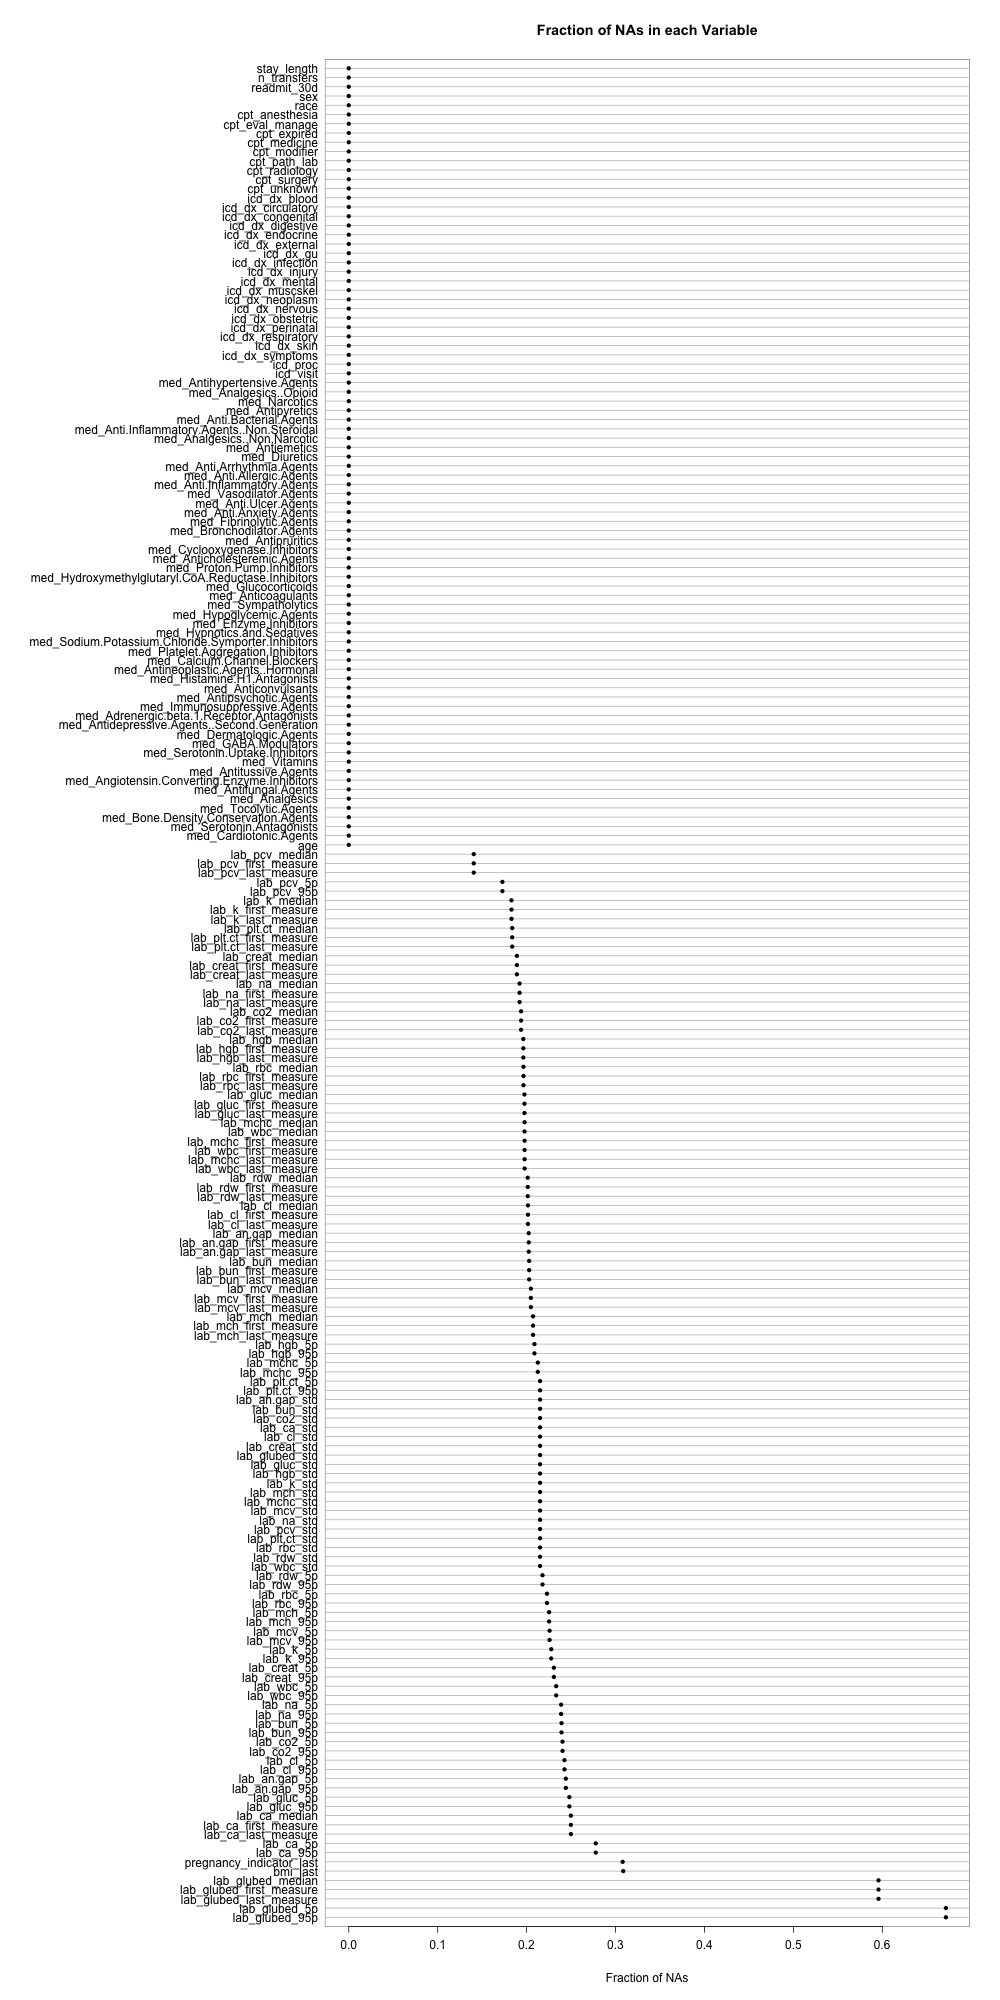

In [16]:
%%R -h 2000 -w 1000 -u px
naplot(na.patterns.all, which='na per var')

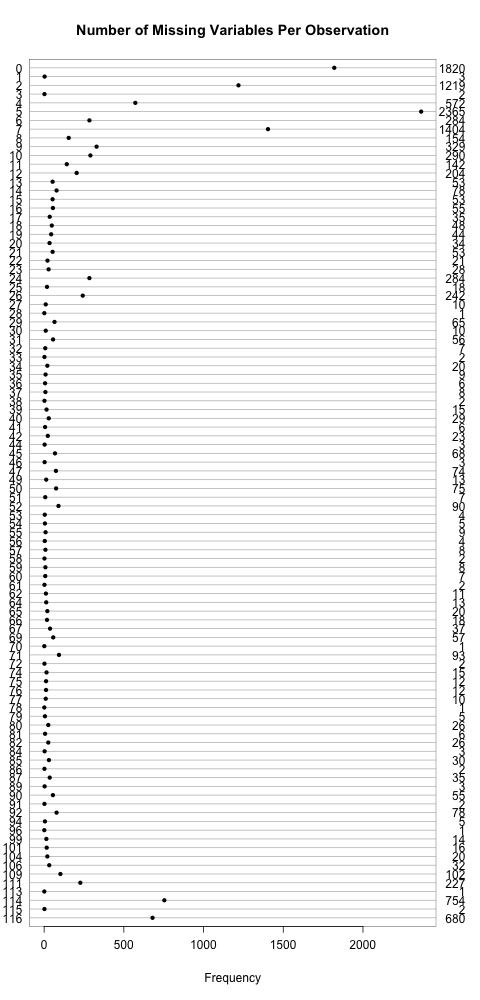

In [17]:
%%R -h 1000 -w 480 -u px
naplot(na.patterns.all, which='na per obs')

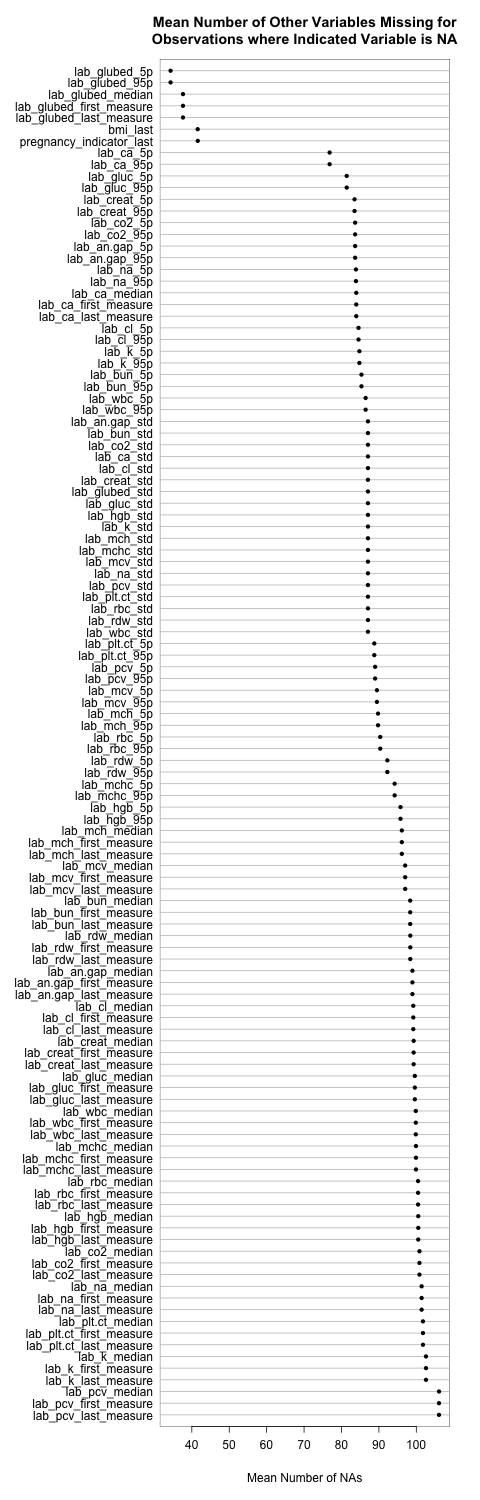

In [19]:
%%R -h 1500 -w 480 -u px
naplot(na.patterns.all, which='mean na')

In [20]:
%%R

# separate categorical & numerical features
cat_cols <- c('sex', 'race', 'pregnancy_indicator', 'readmit_30d')
num_cols <- names(train[, !names(train) %in% cat_cols])

# convert all predictors into R formula
vars <- paste(num_cols, collapse=' + ')
formula <- paste('~', vars)

# attempting all variables (but singular matrix resulted)
#formula <- as.formula(paste(formula), ' + sex-1 + race-1 + pregnancy_indicator-1'))

# numerical values only
formula <- as.formula(paste(formula))

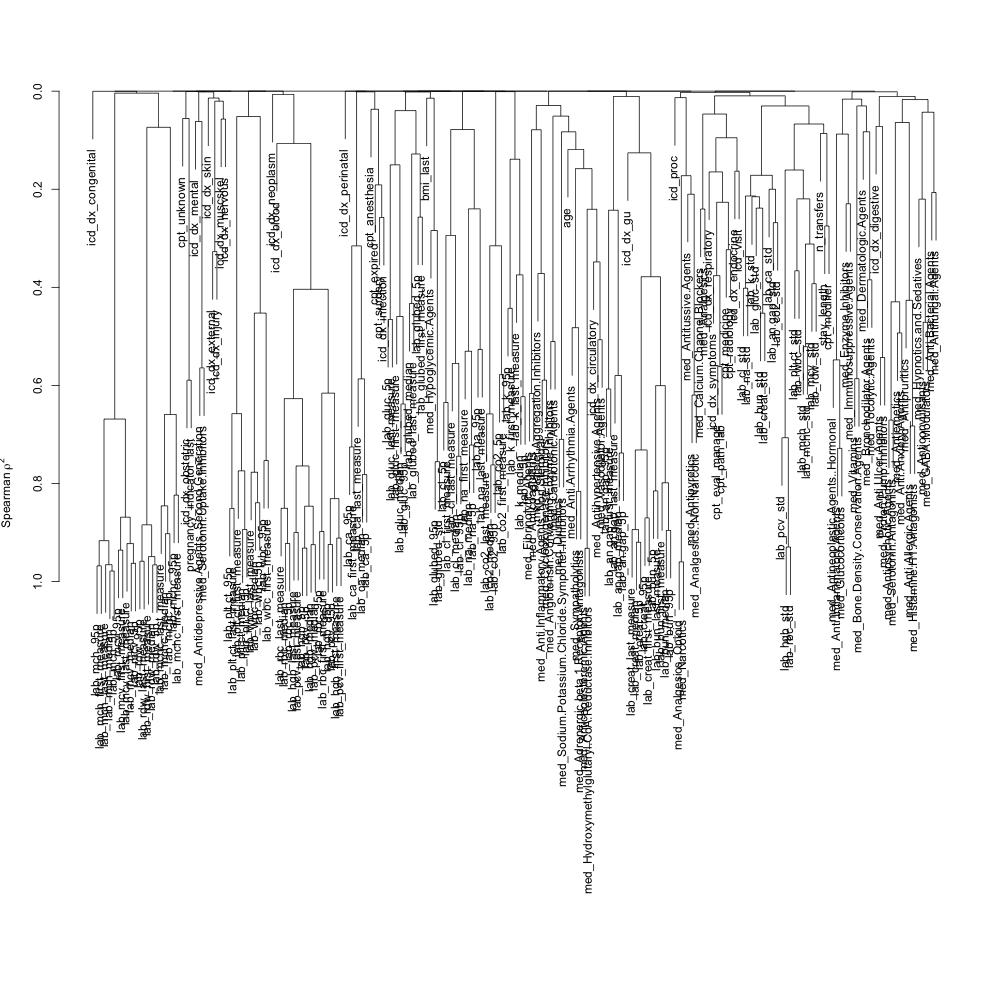

In [16]:
%%R -h 1250 -w 1000 -u px

vc <- varclus(formula, sim='spearman', data=train)
plot(vc) 

## Single Imputation with `Hmisc::transcan()` in R

*Note:* This step takes a while to run even with a single imputation.  It is recommended to load the existing .RData file in the subsequent step. 

Convergence criterion:7.777 1.658 1.068 0.848 0.548 
Convergence in 6 iterations
R-squared achieved in predicting each variable:

                                       stay_length 
                                             0.887 
                                       n_transfers 
                                             0.632 
                                       readmit_30d 
                                             0.095 
                                               sex 
                                             0.257 
                                              race 
                                             0.264 
                                    cpt_anesthesia 
                                             0.183 
                                   cpt_eval_manage 
                                             0.897 
                                       cpt_expired 
                                             0.784 
                                      

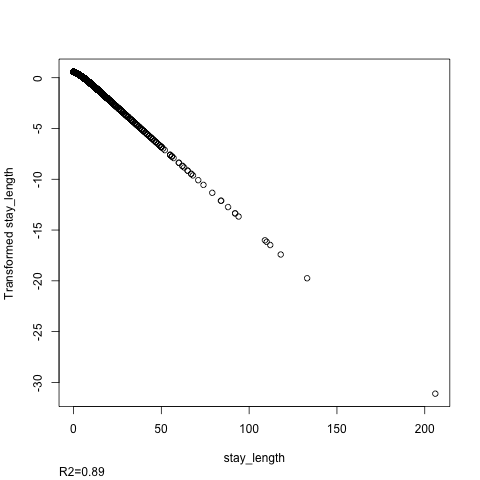

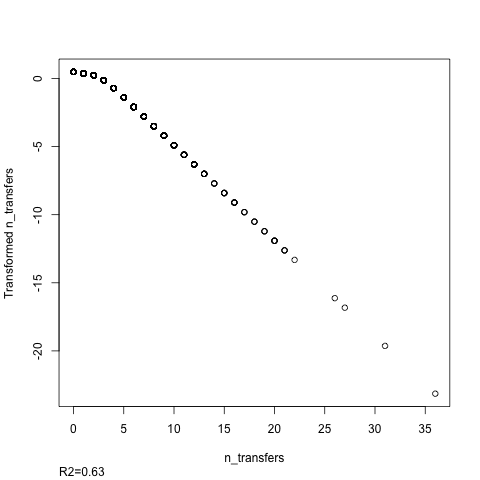

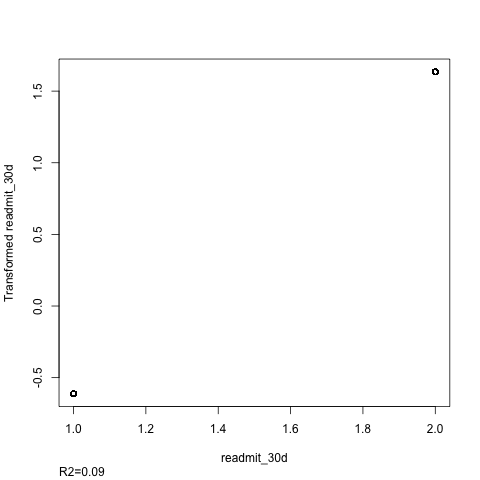

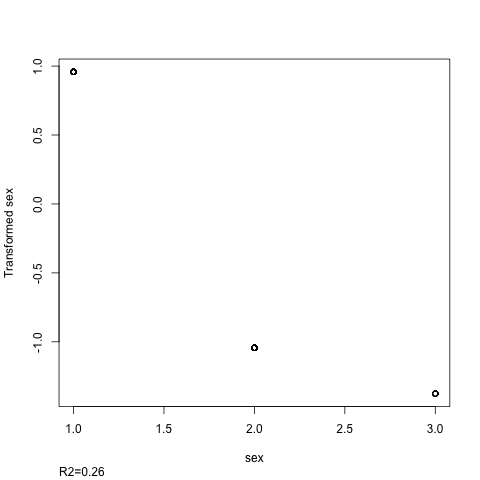

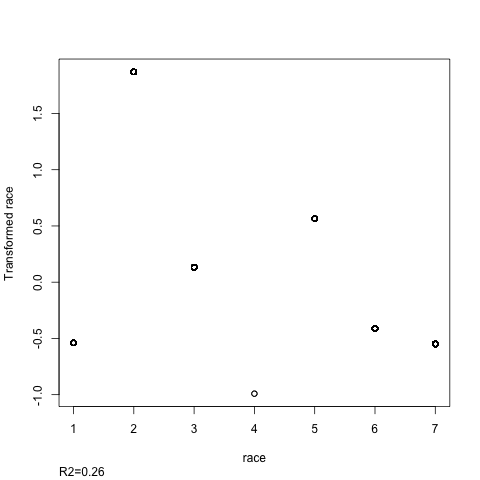

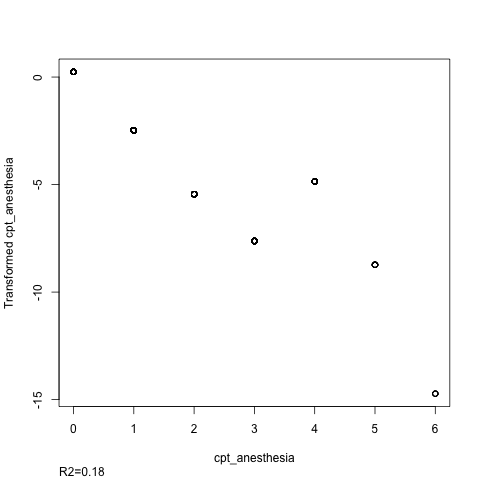

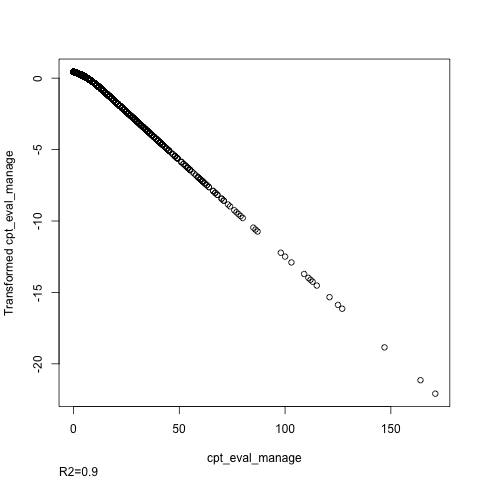

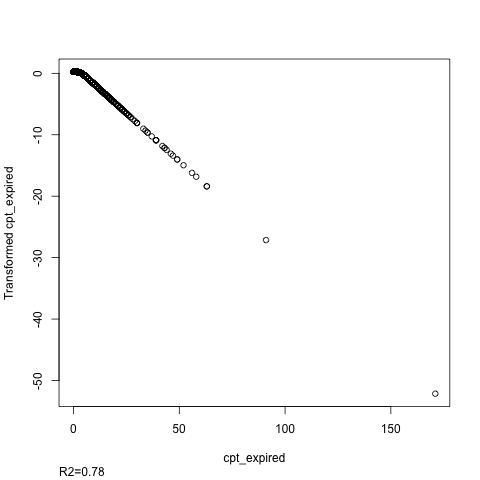

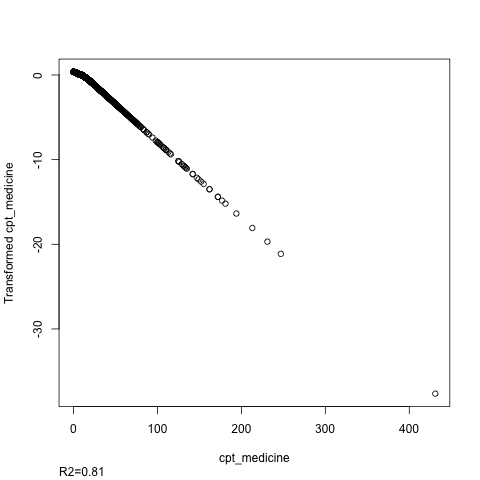

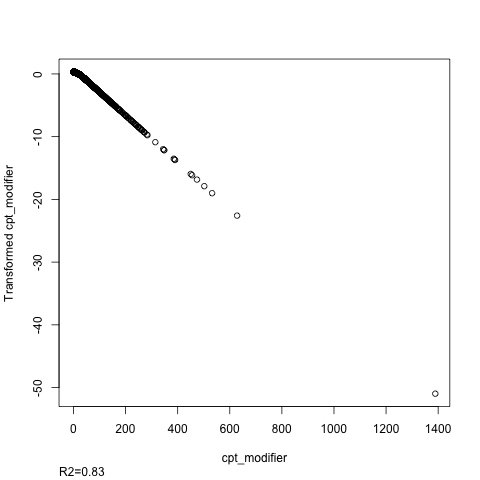

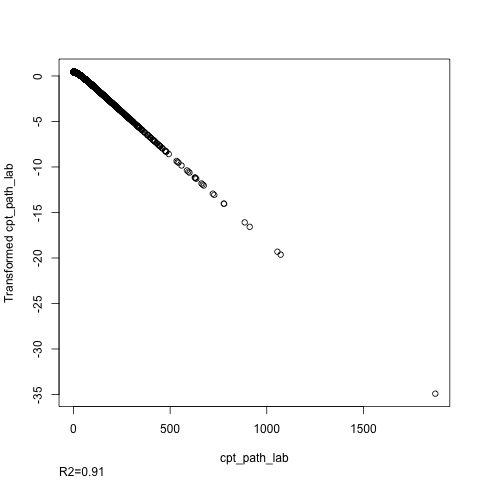

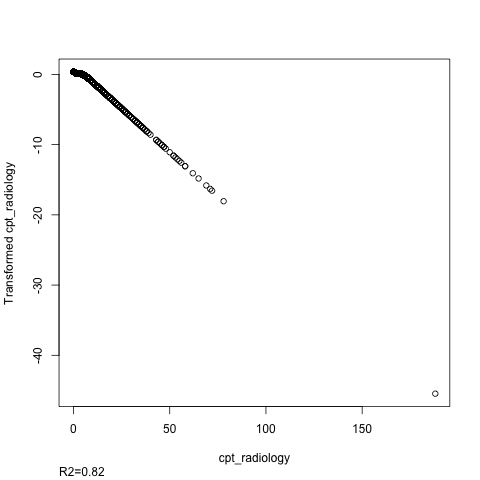

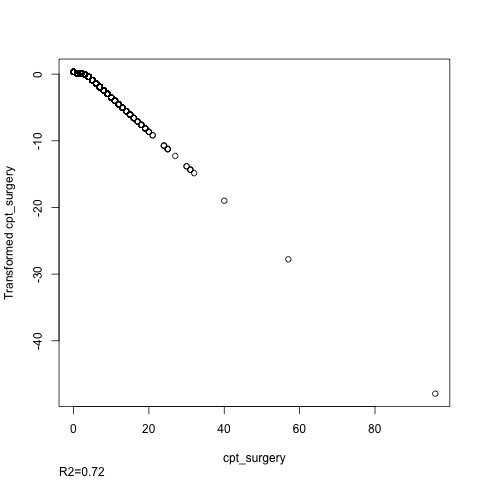

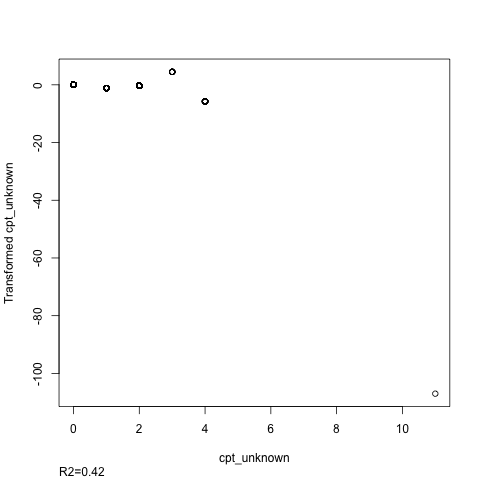

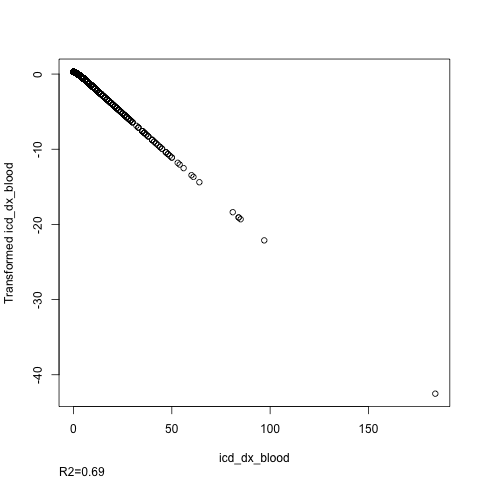

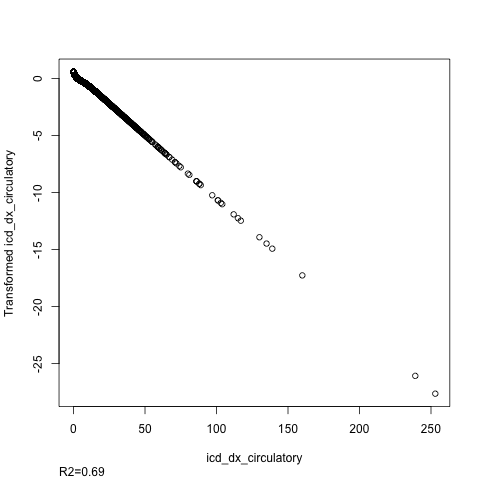

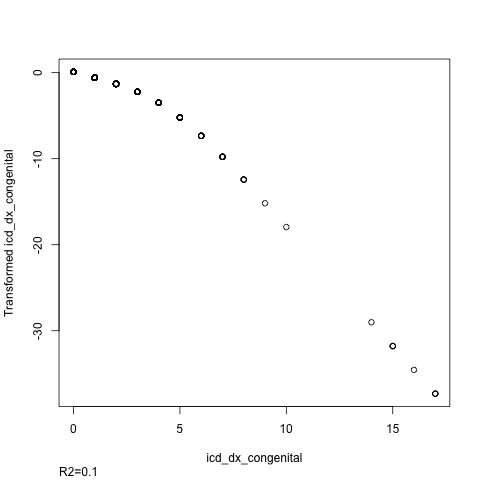

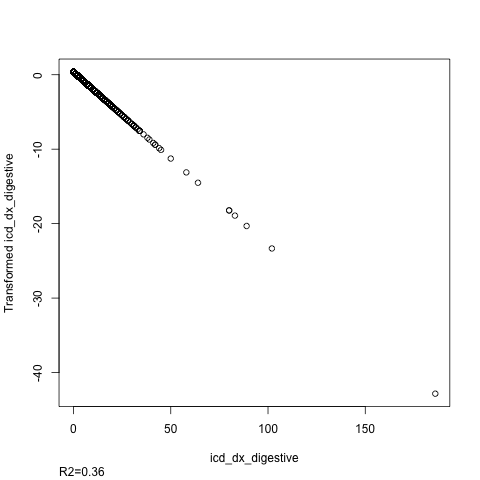

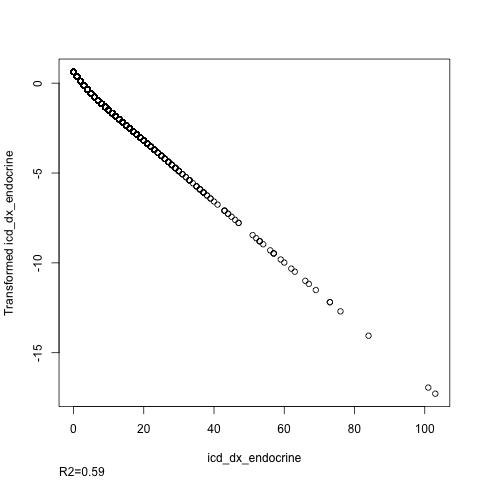

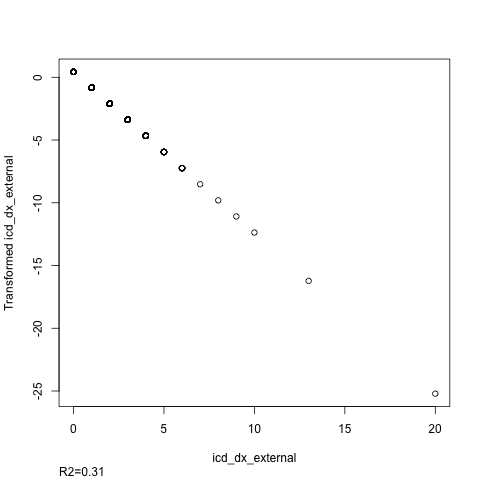

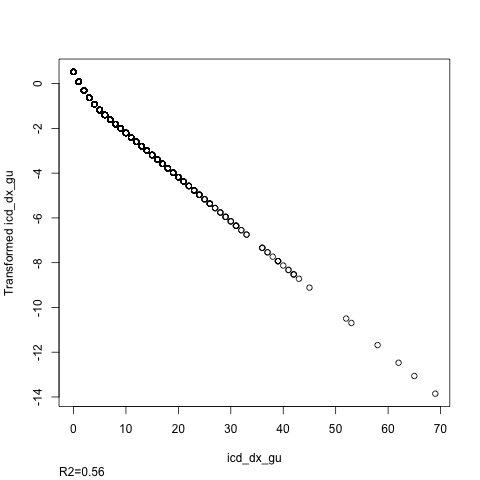

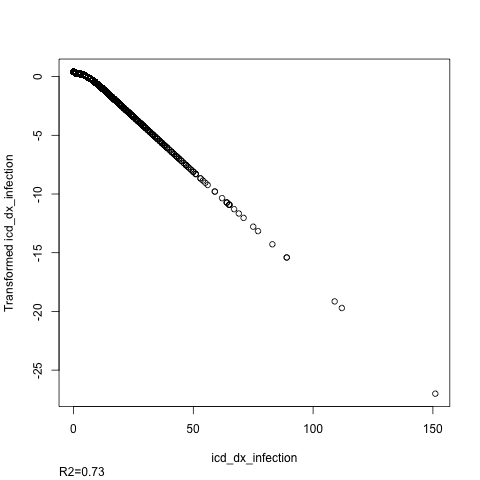

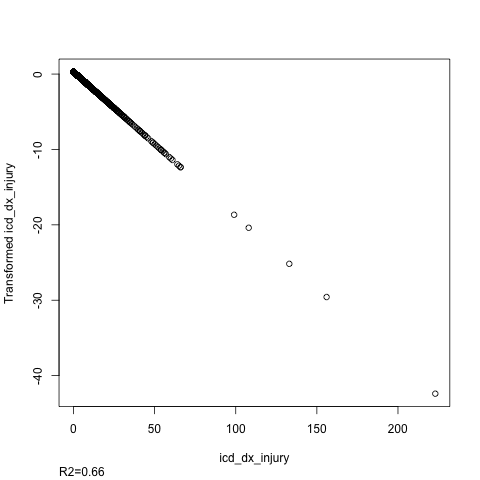

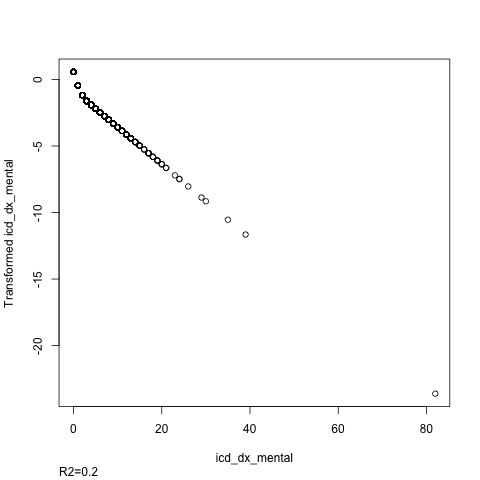

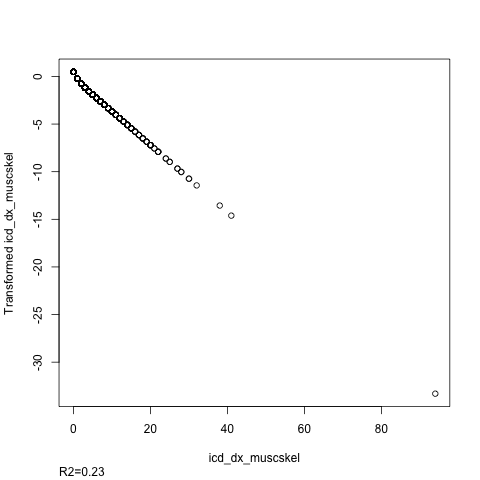

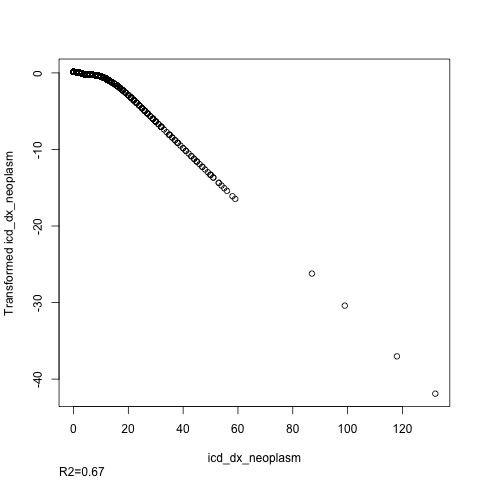

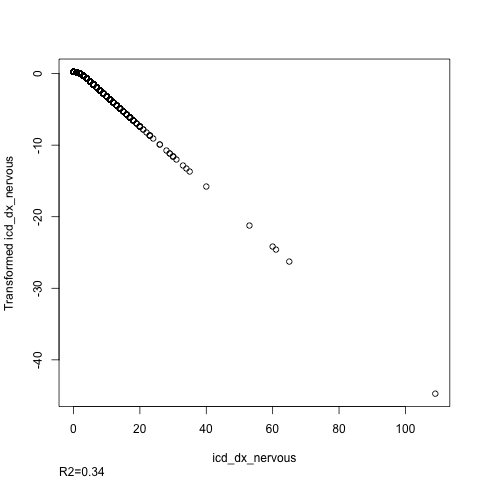

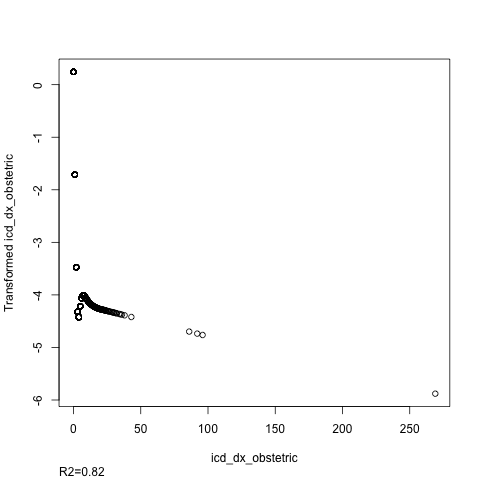

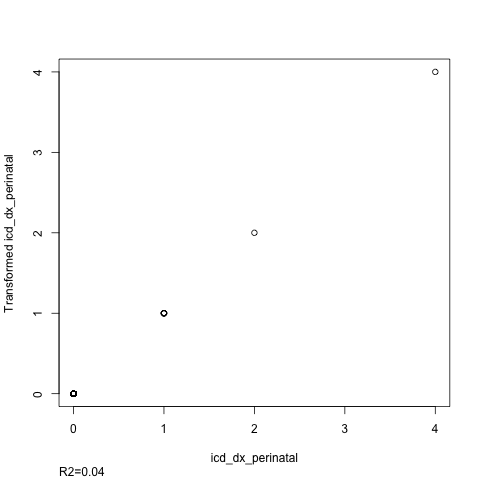

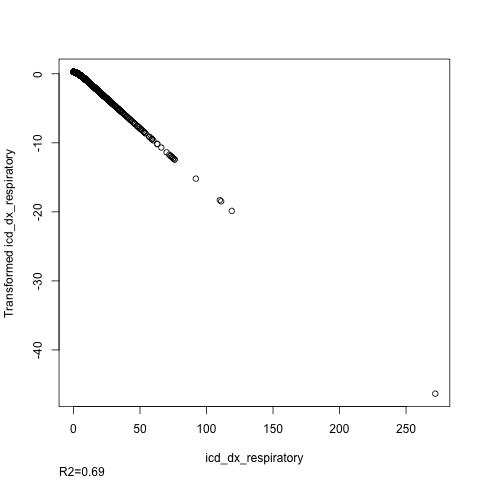

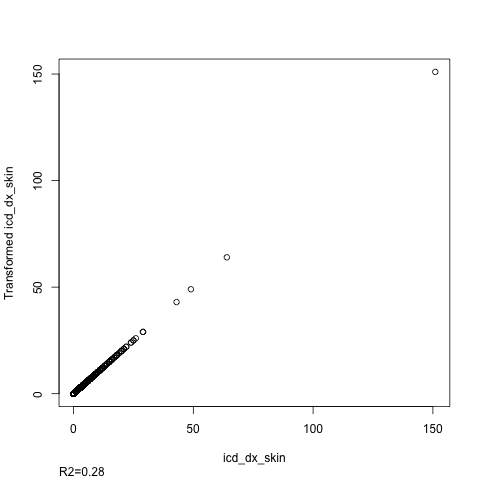

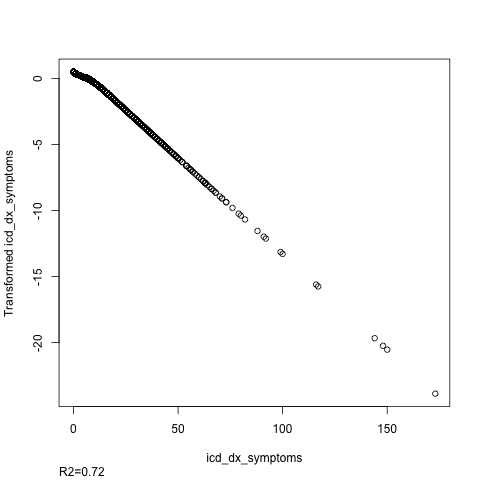

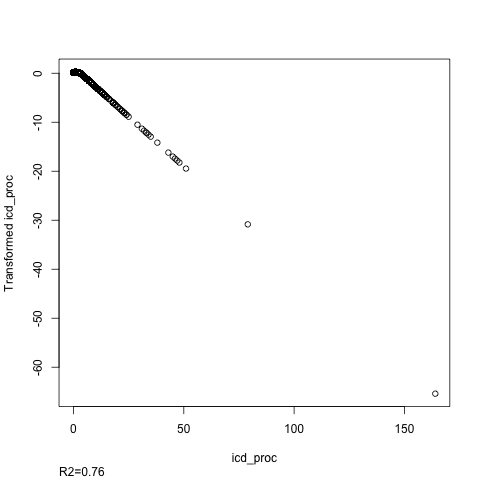

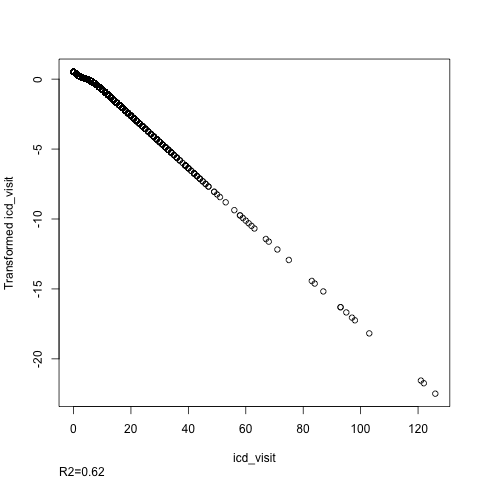

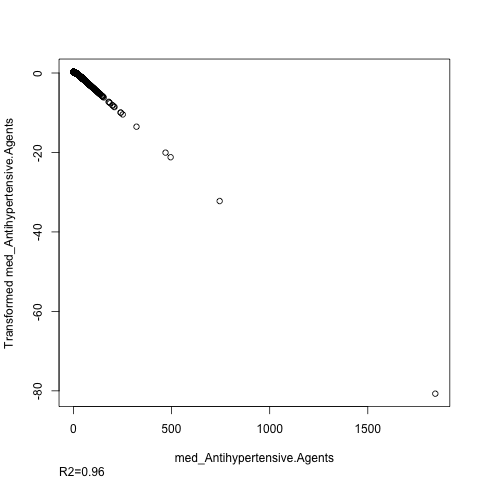

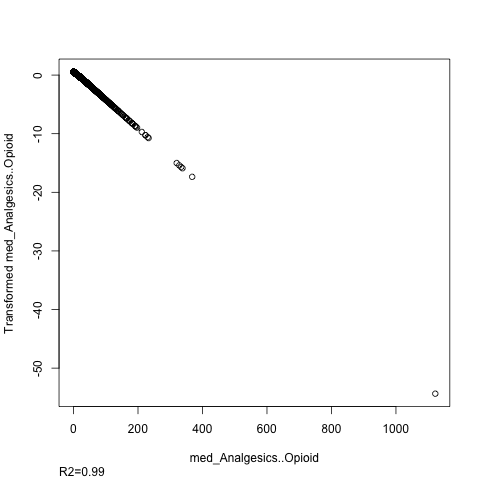

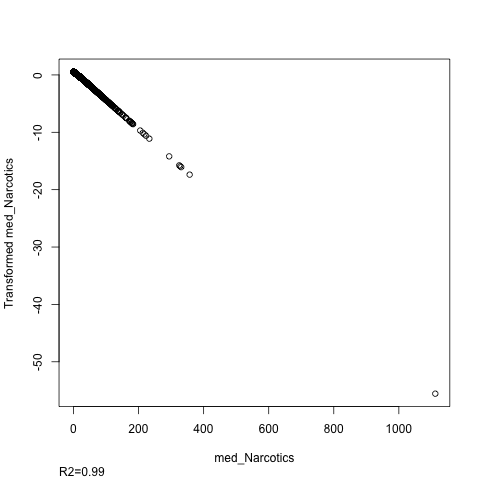

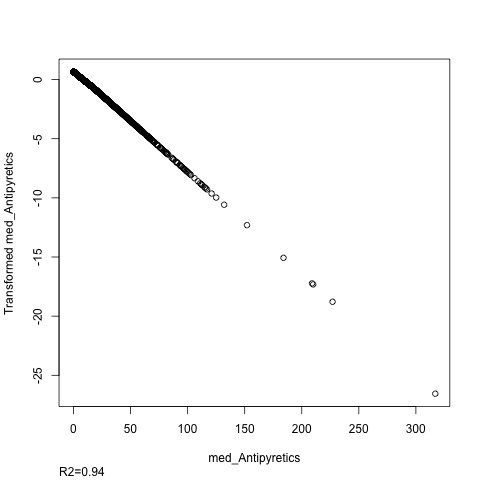

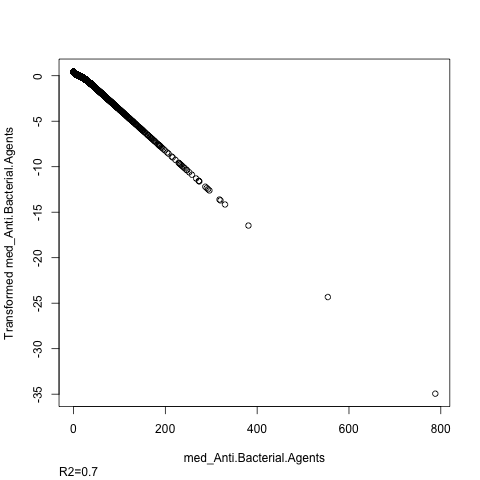

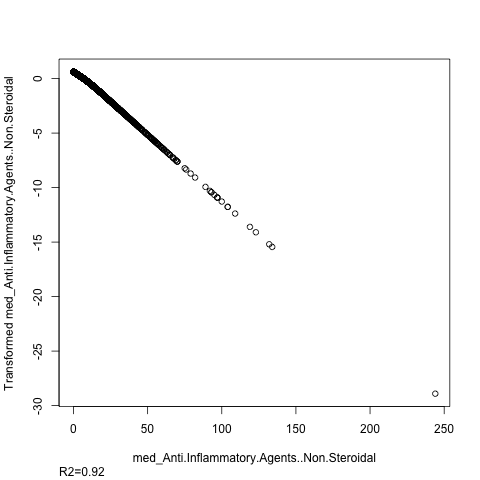

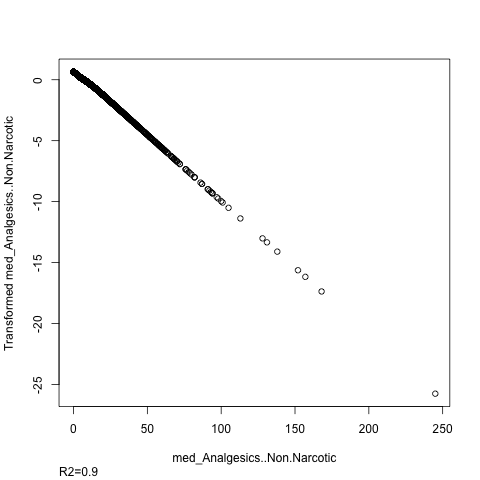

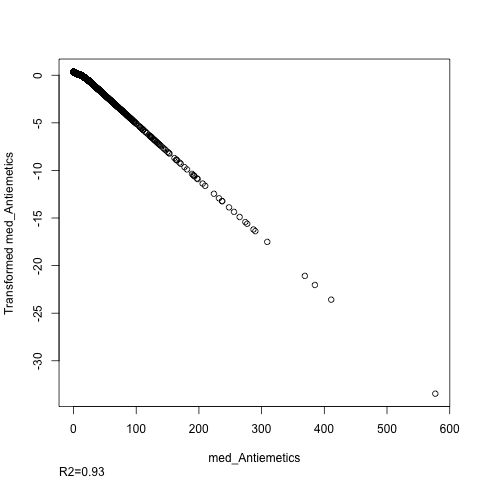

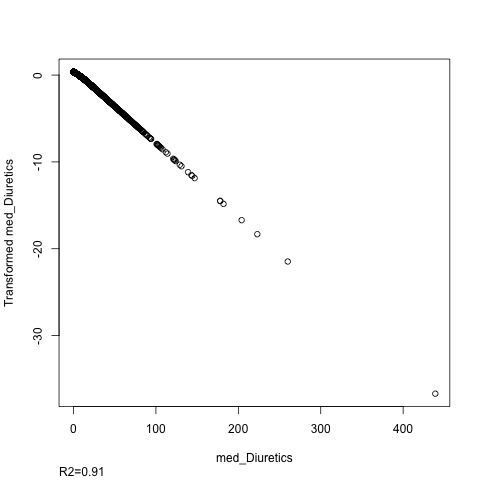

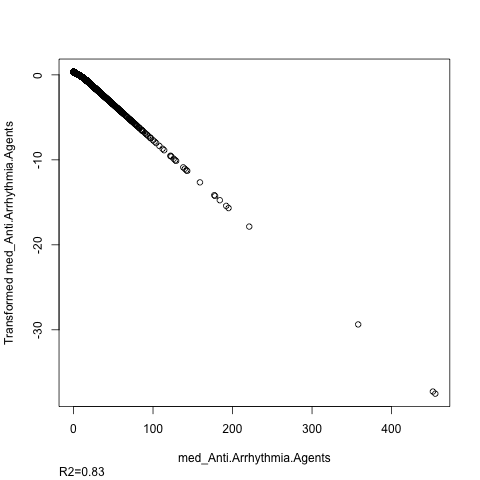

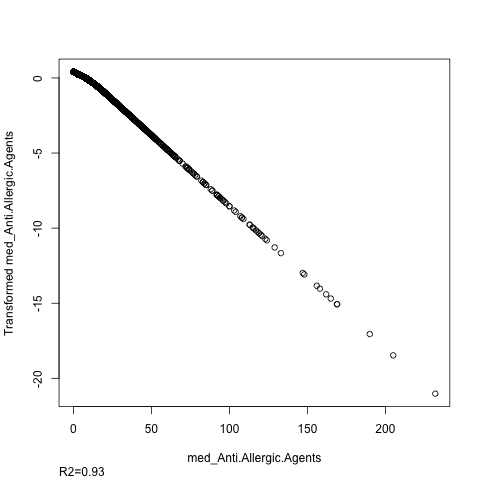

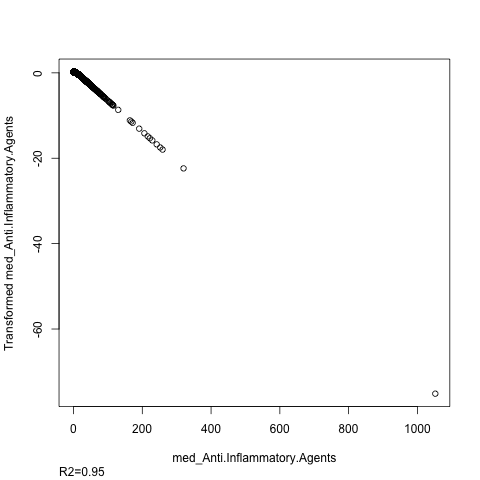

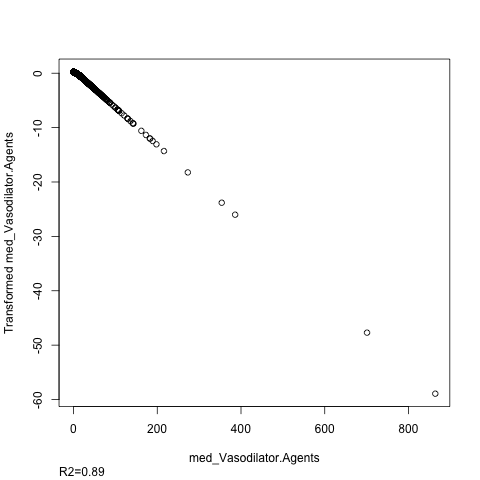

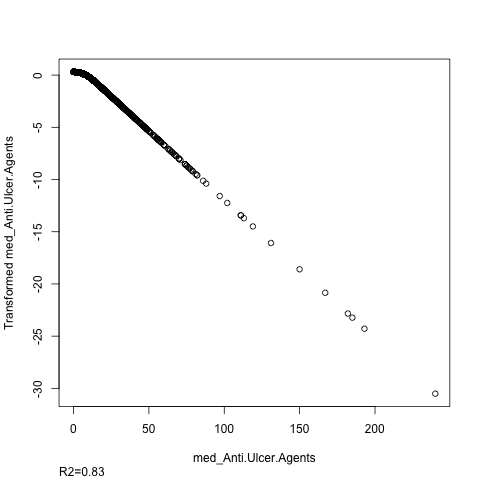

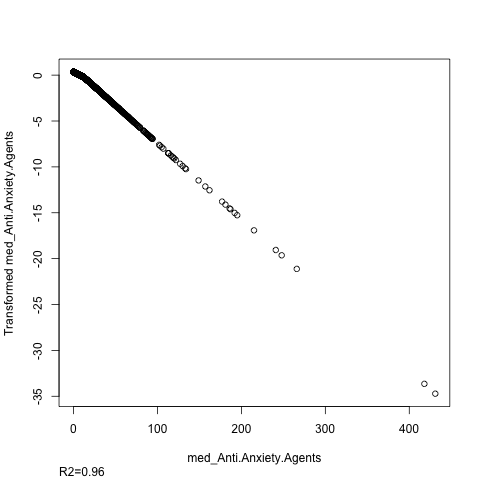

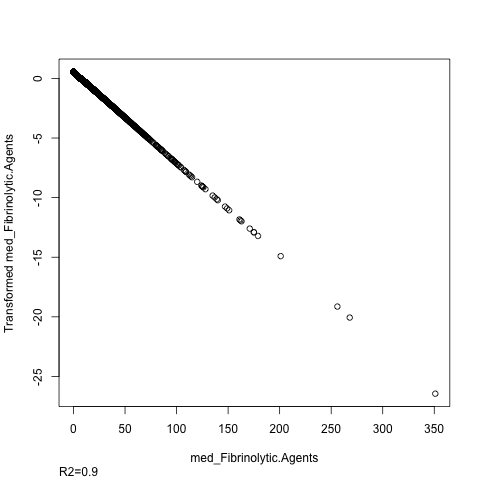

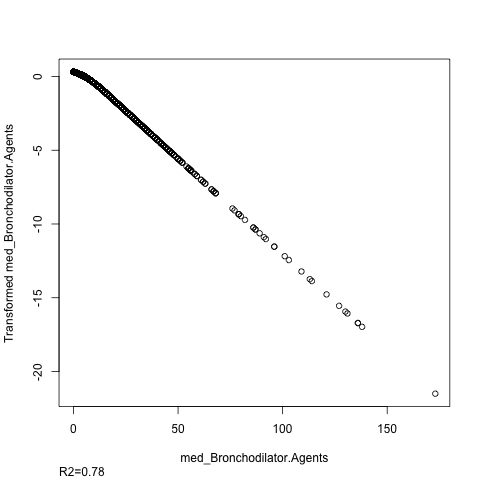

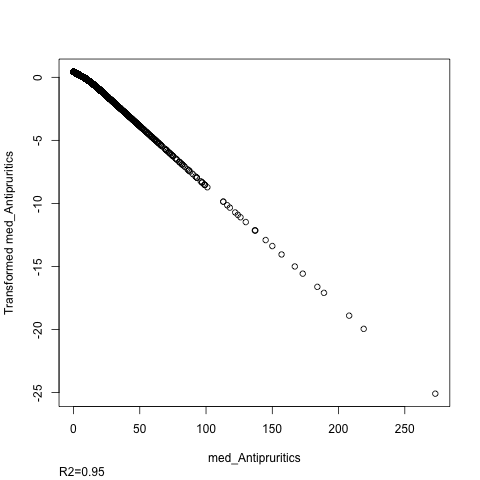

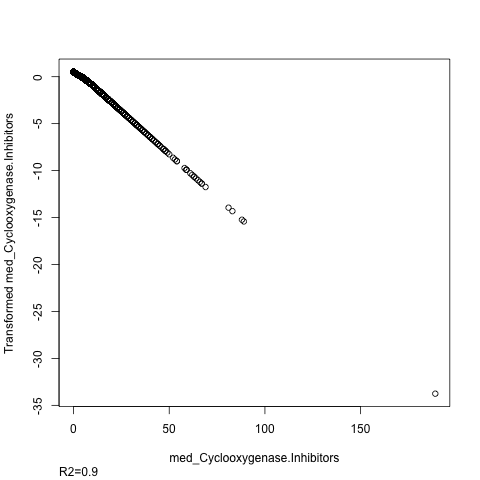

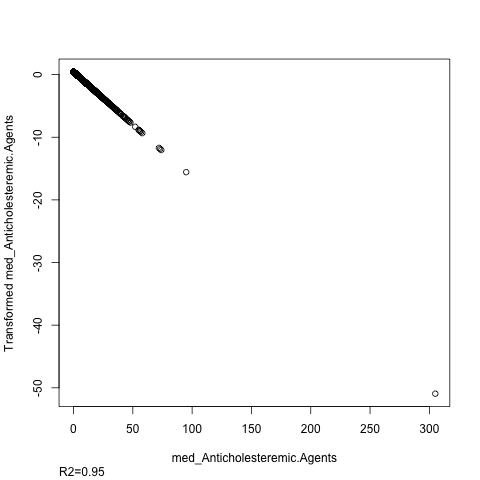

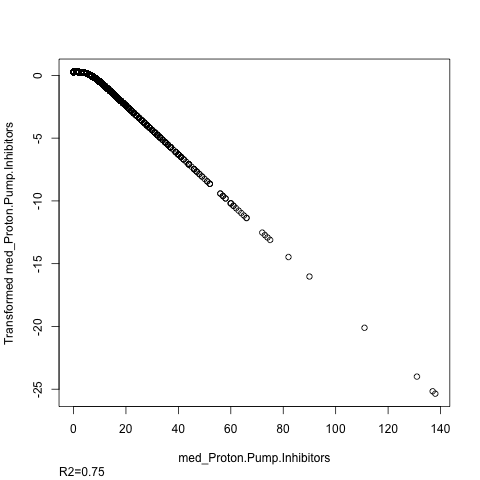

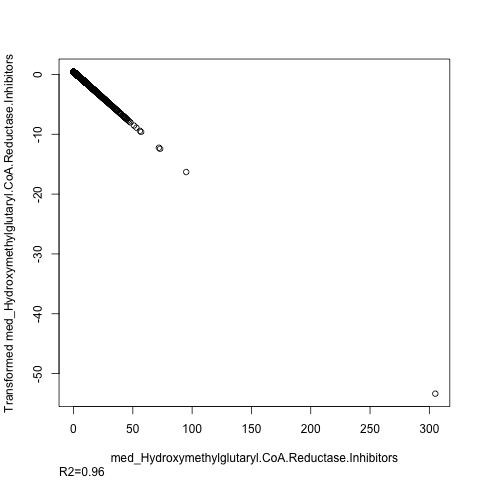

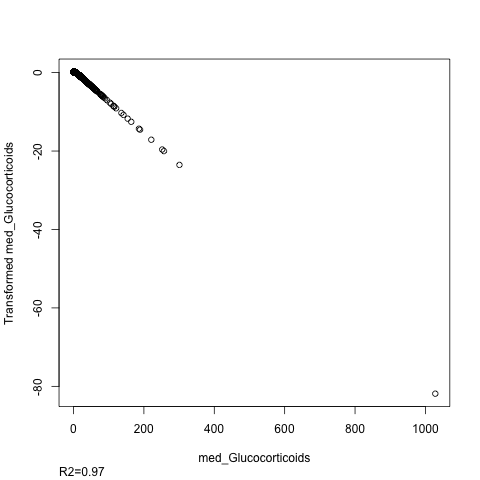

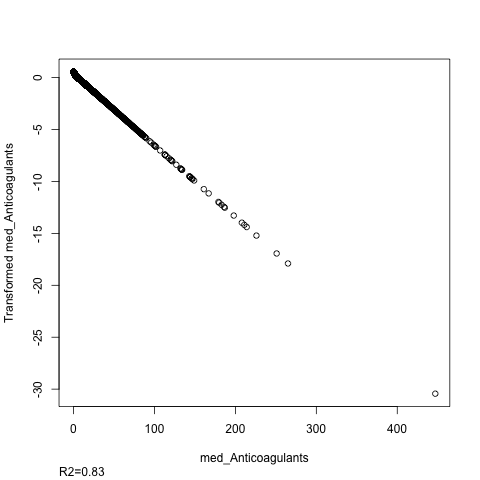

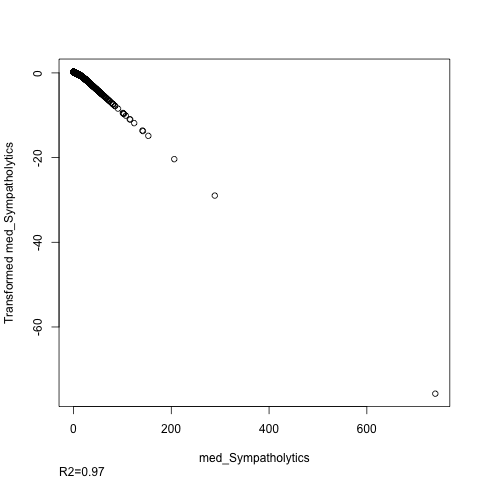

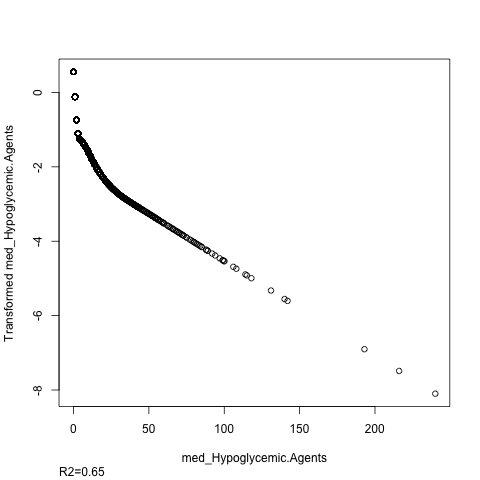

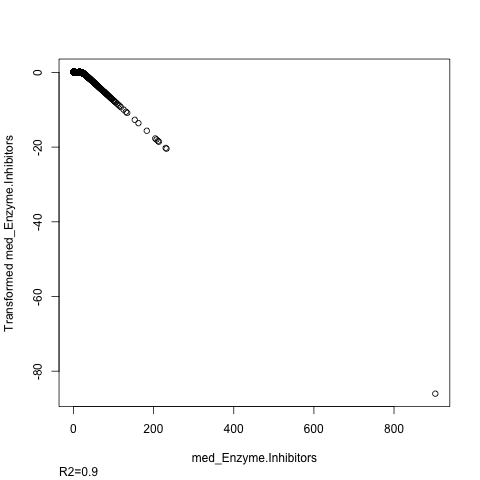

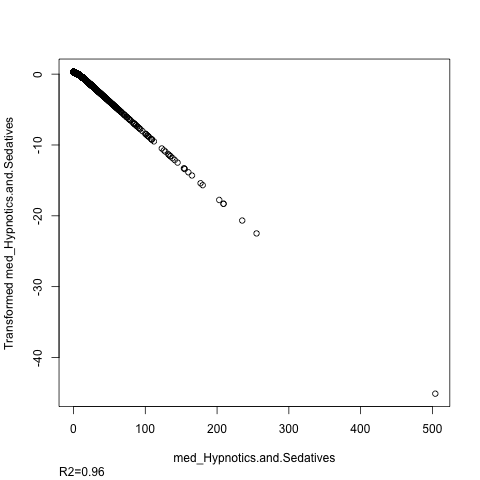

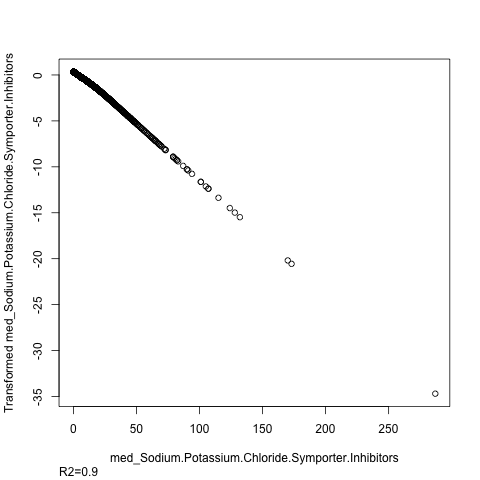

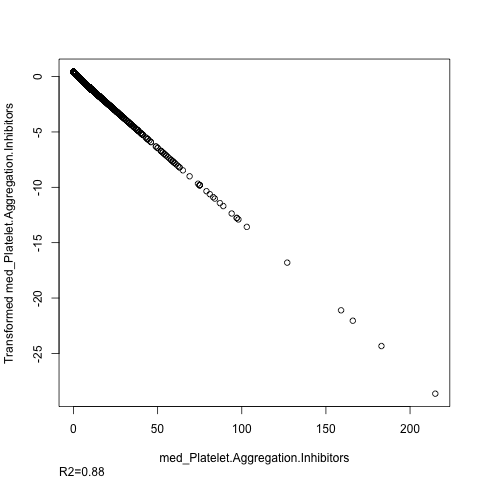

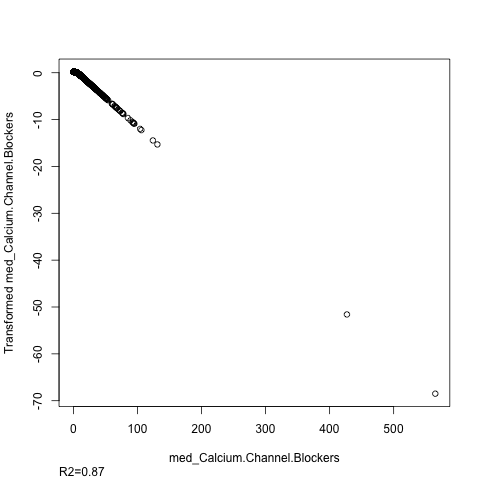

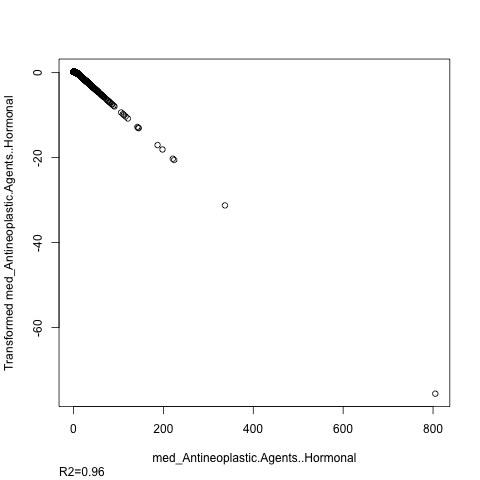

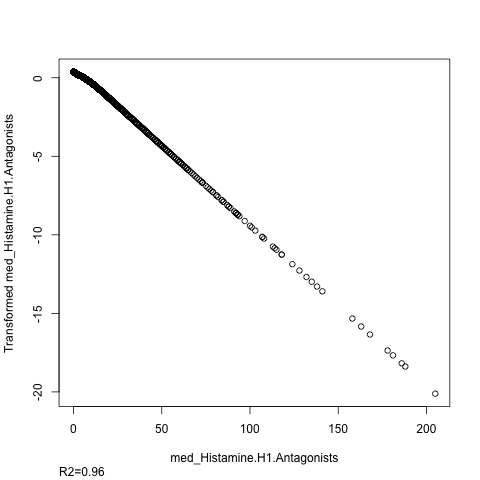

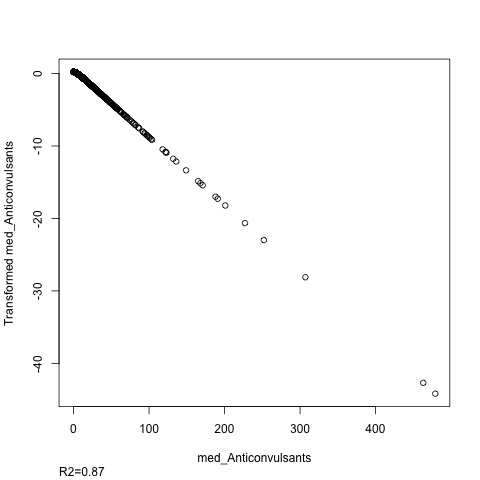

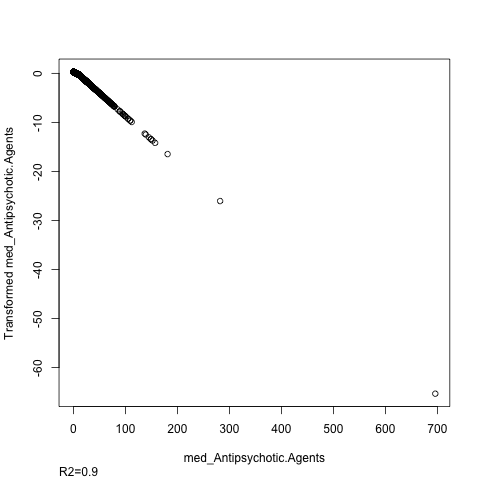

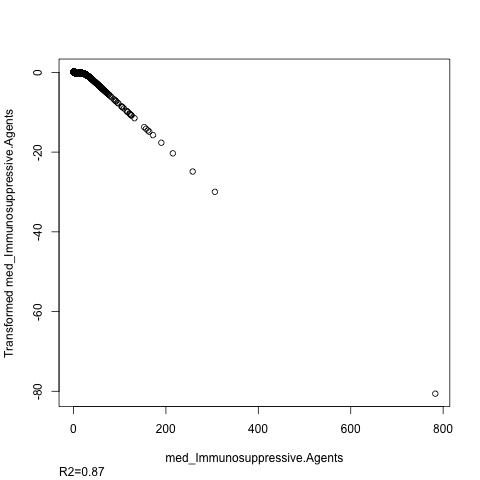

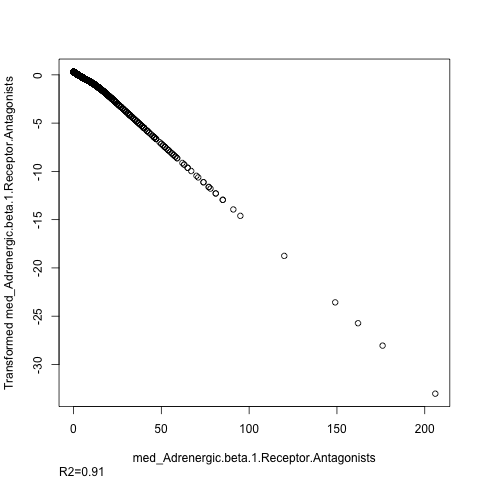

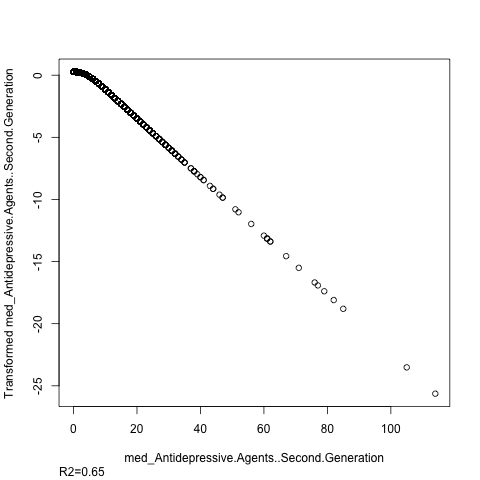

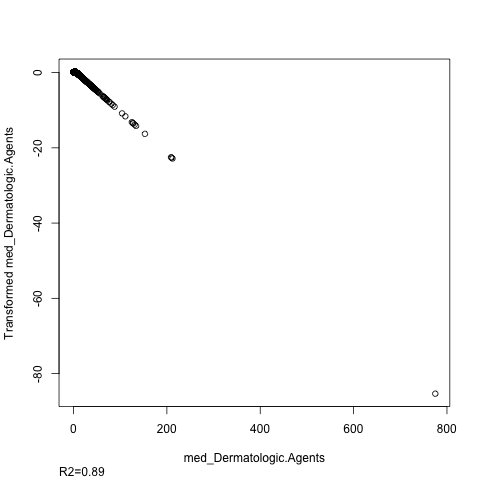

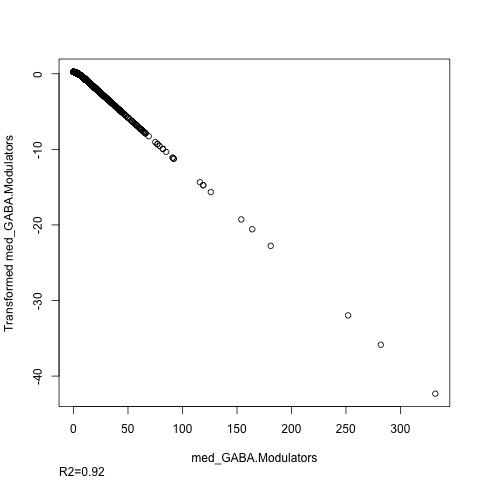

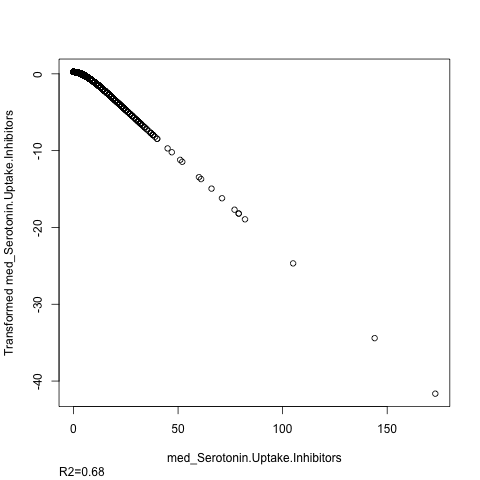

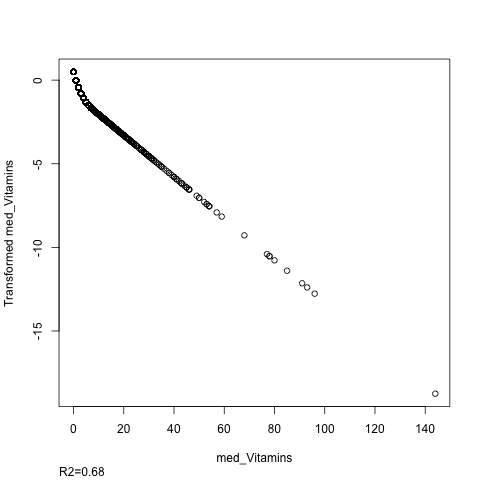

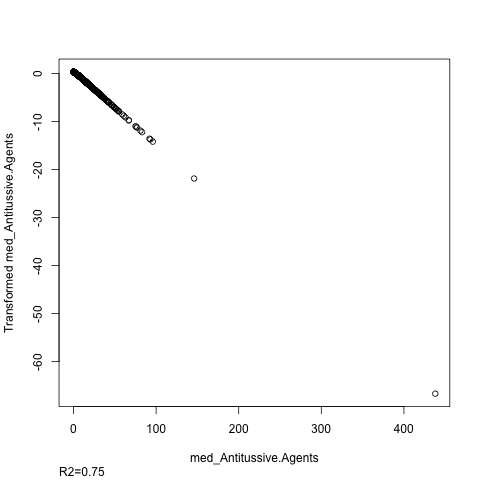

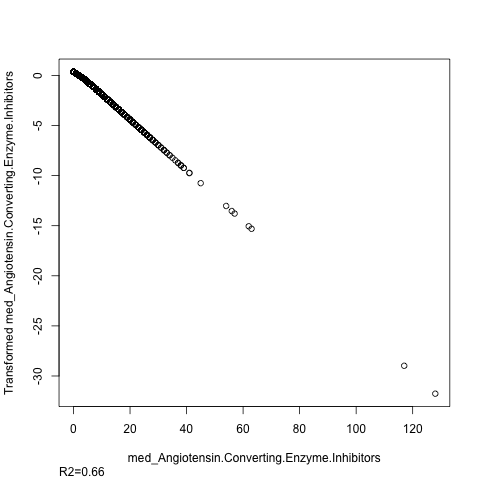

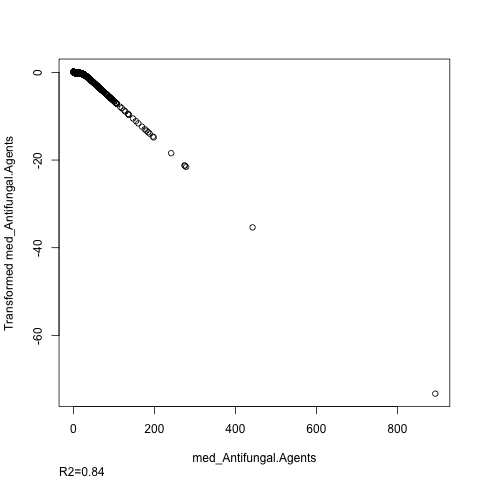

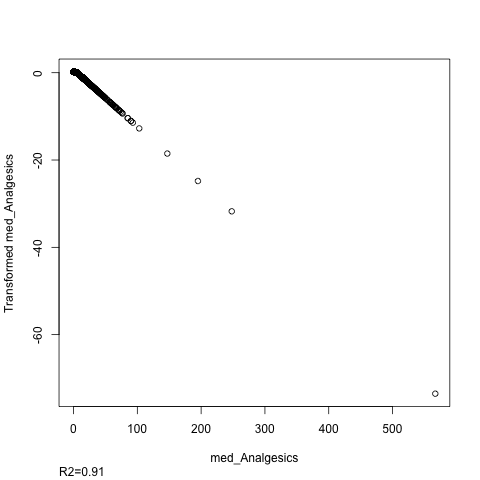

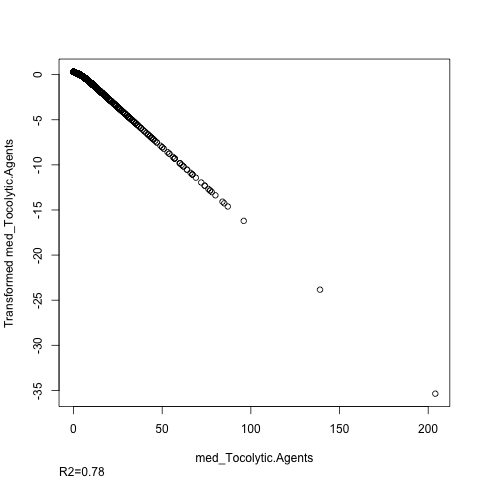

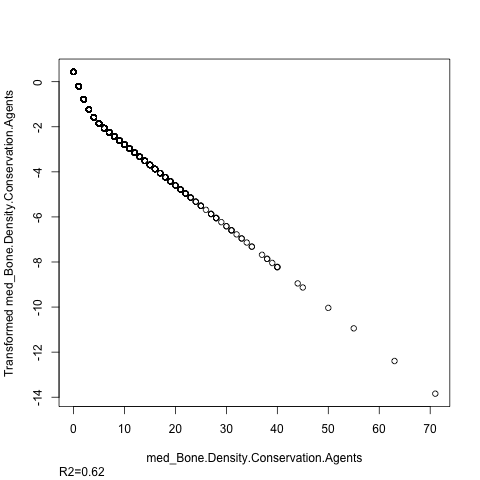

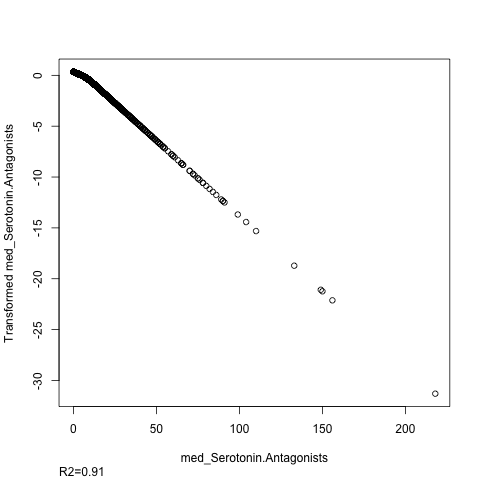

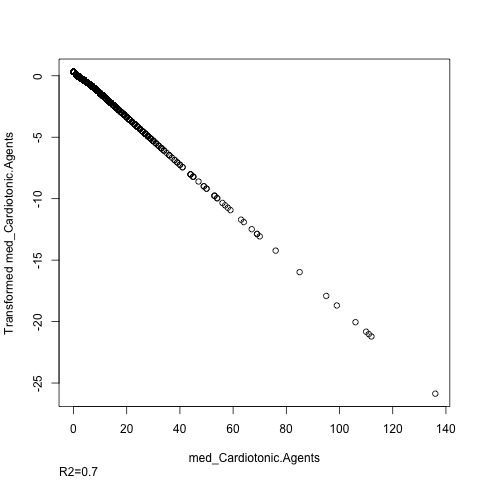

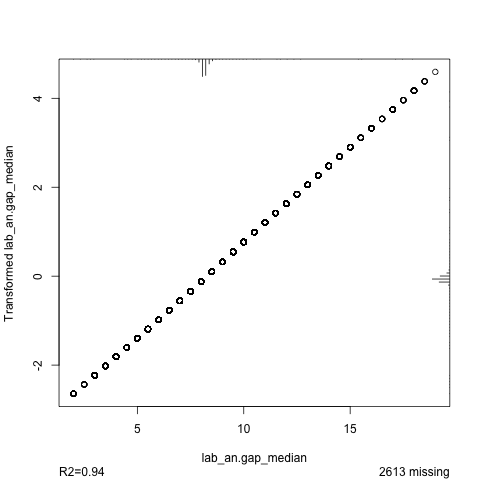

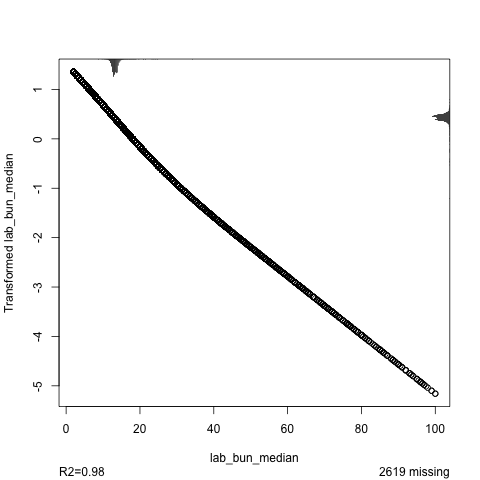

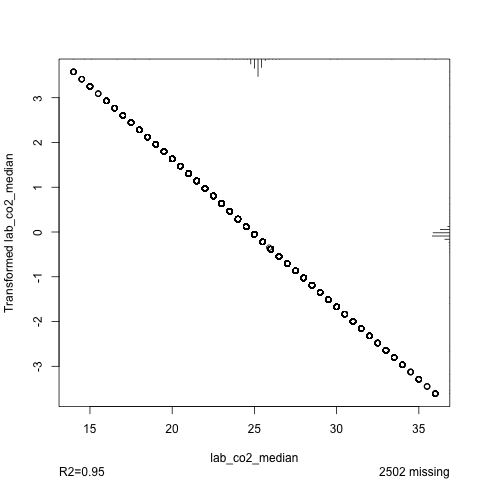

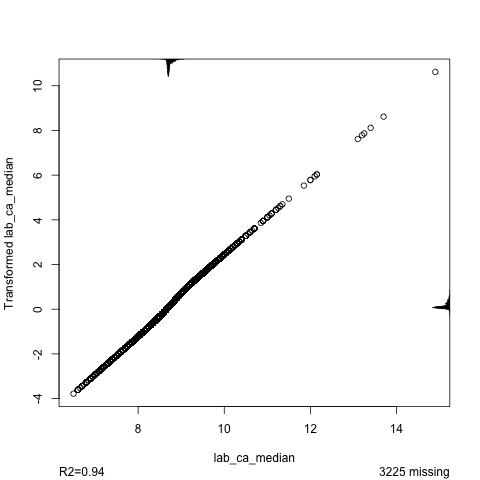

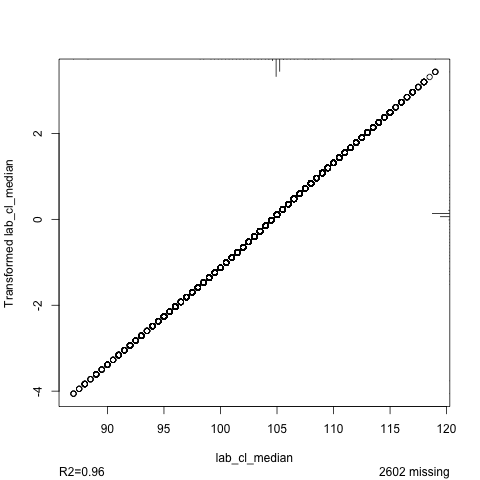

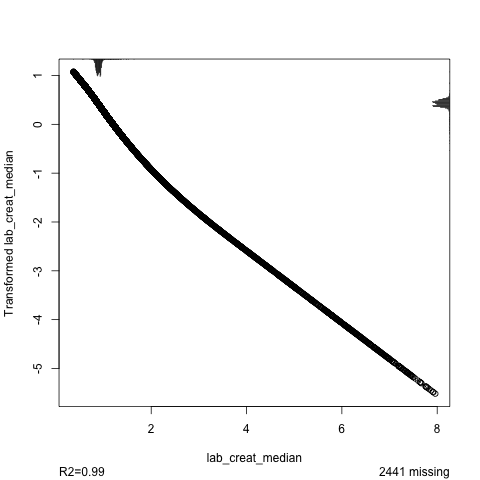

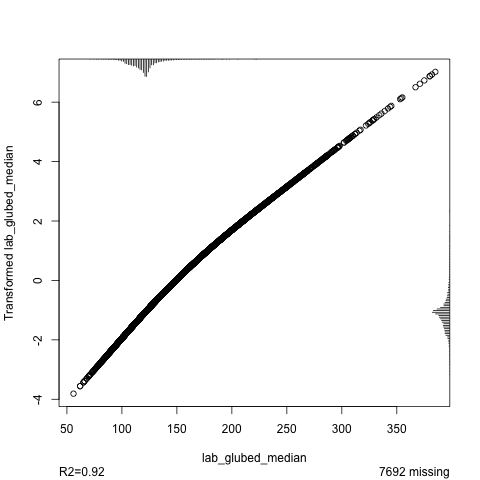

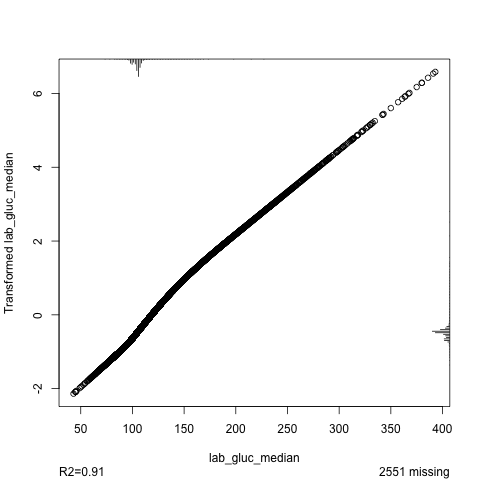

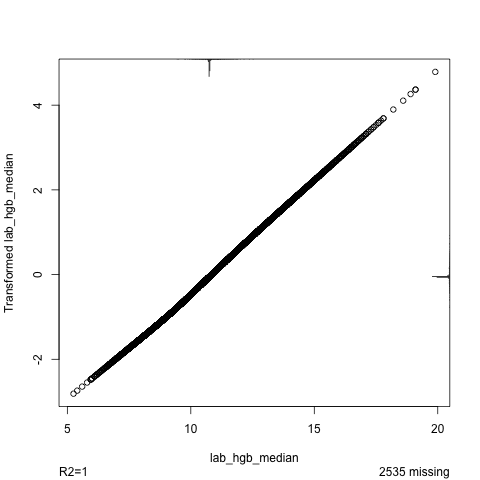

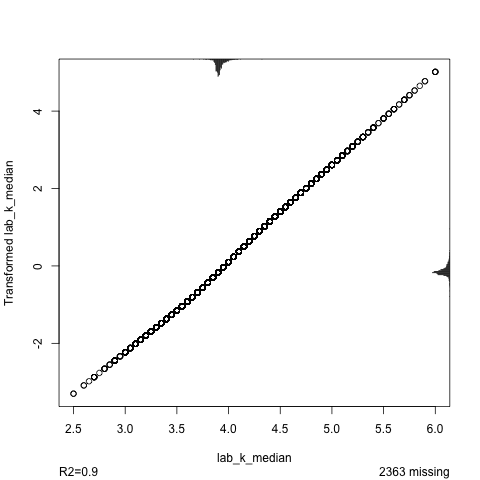

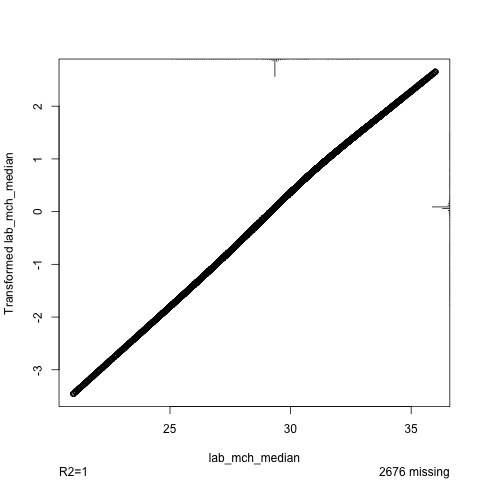

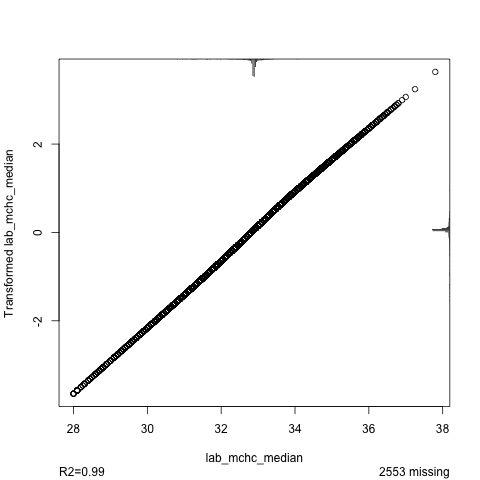

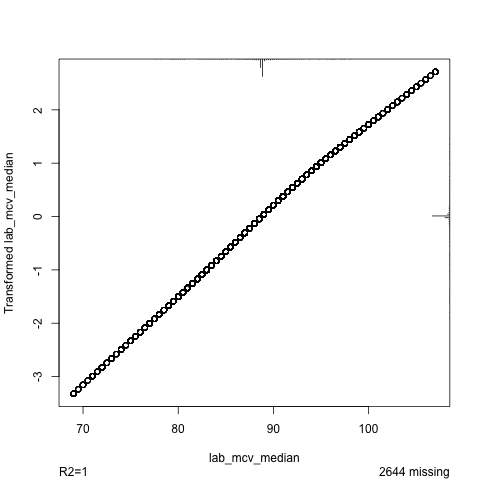

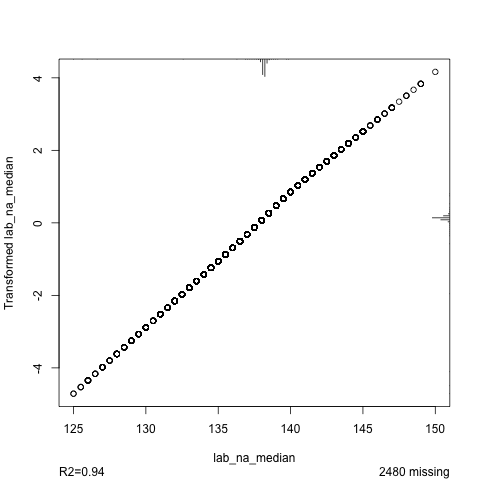

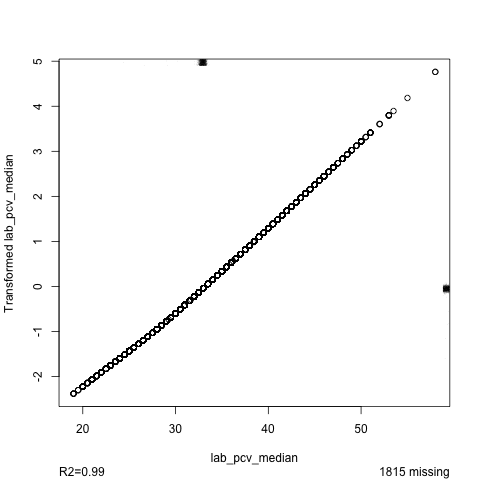

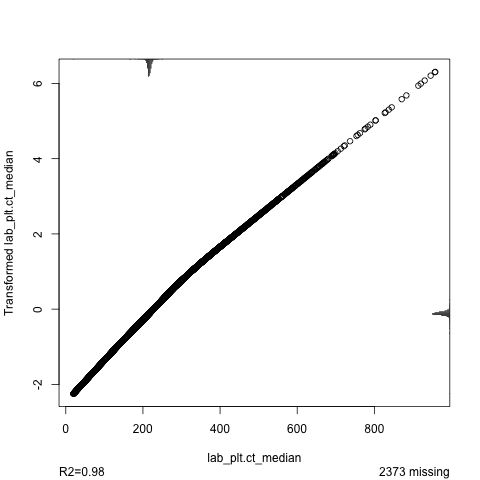

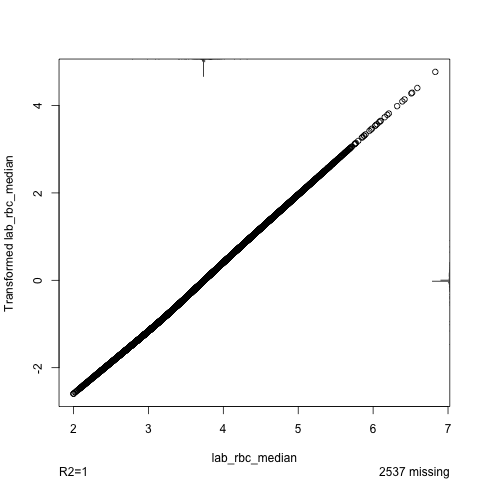

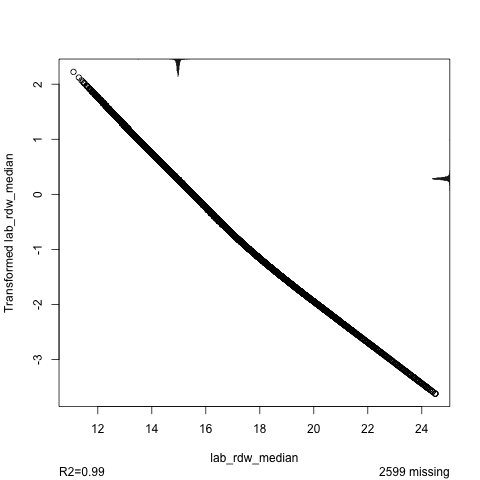

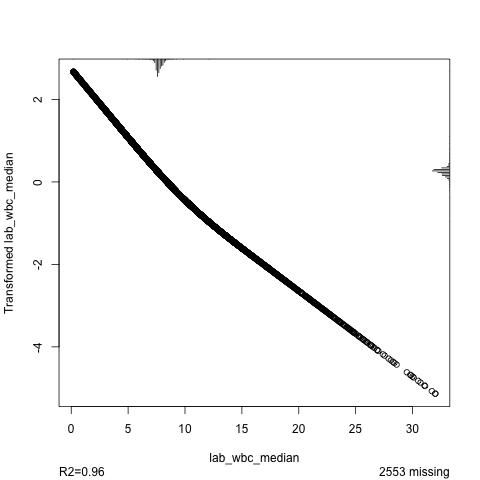

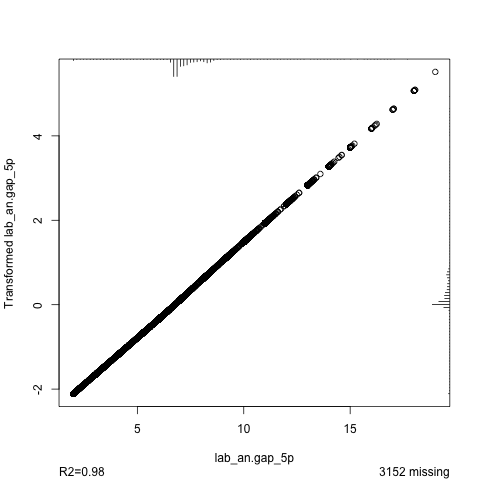

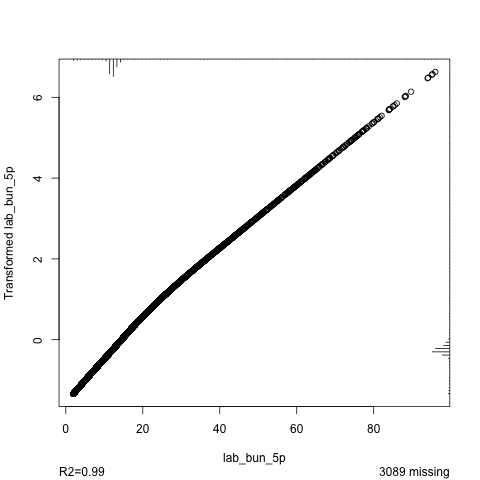

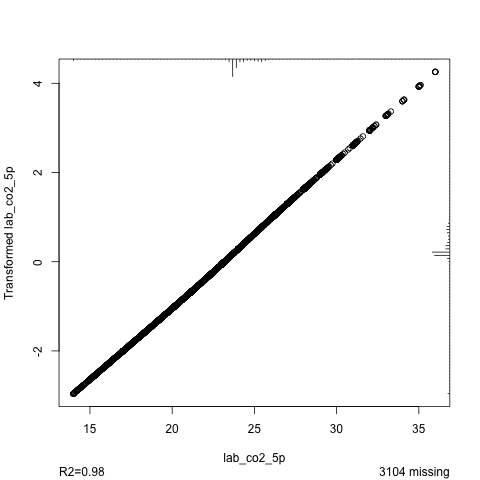

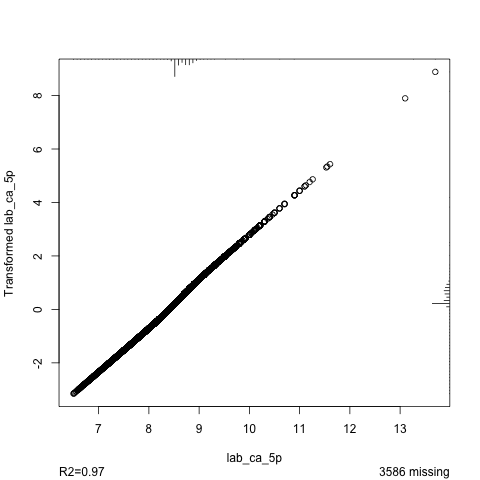

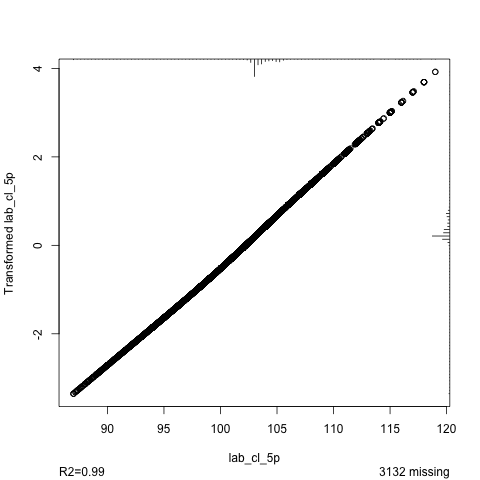

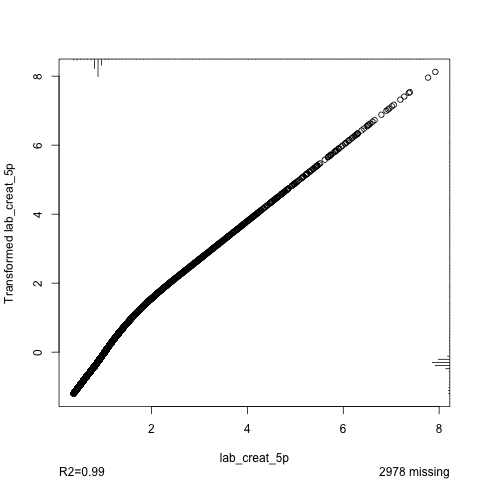

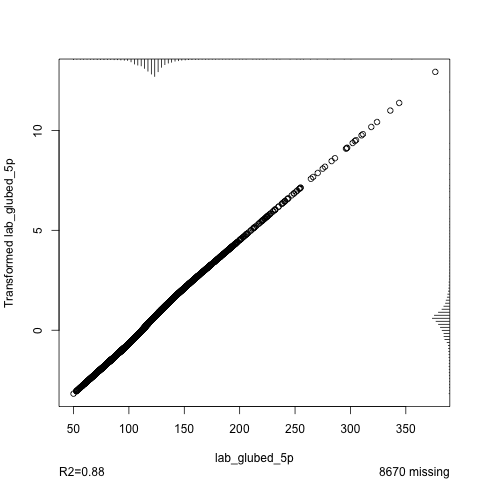

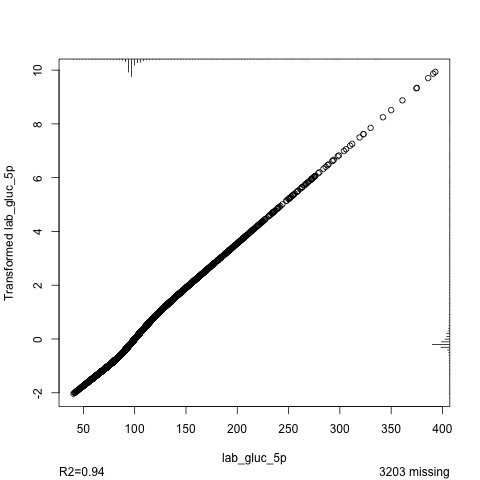

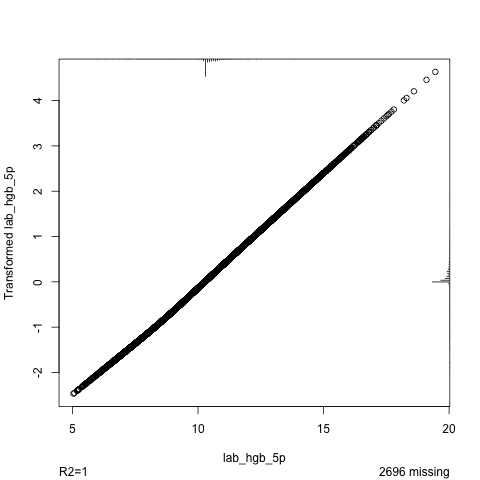

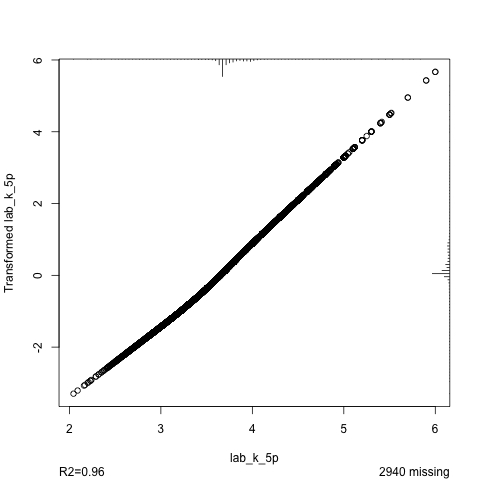

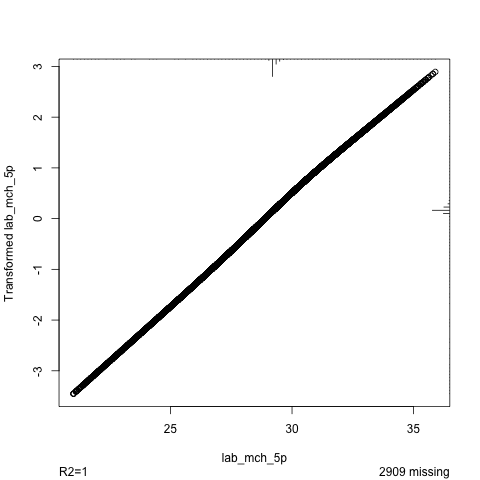

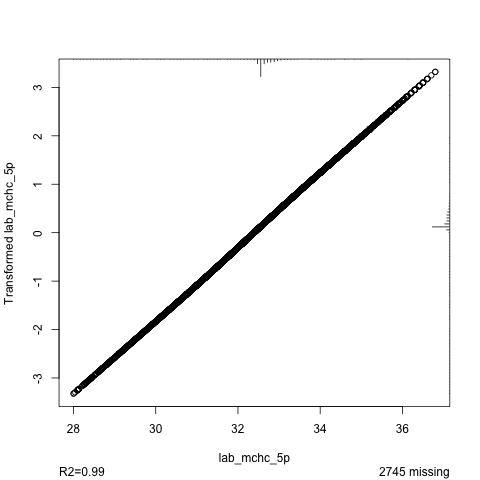

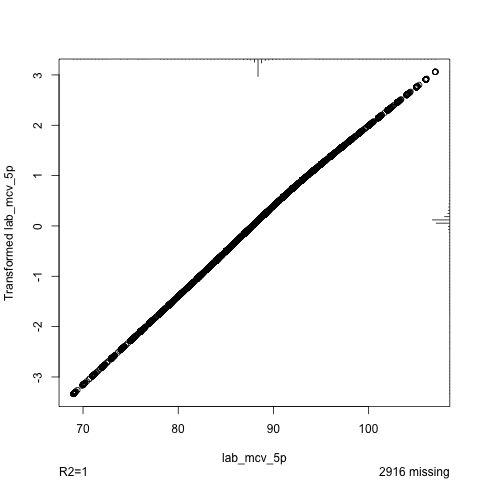

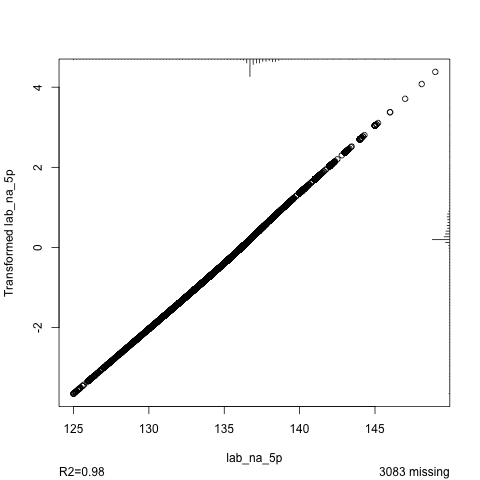

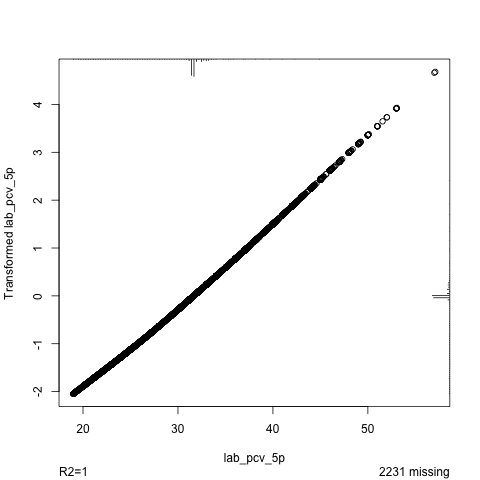

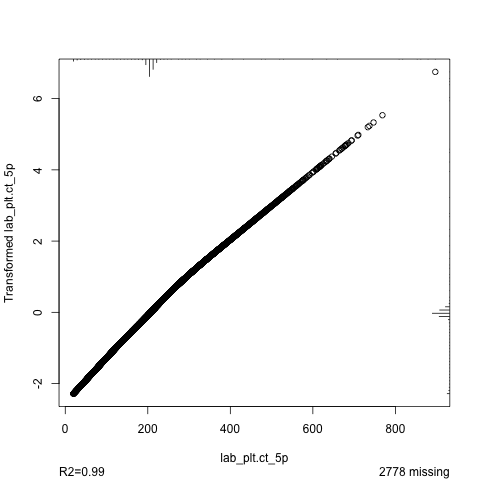

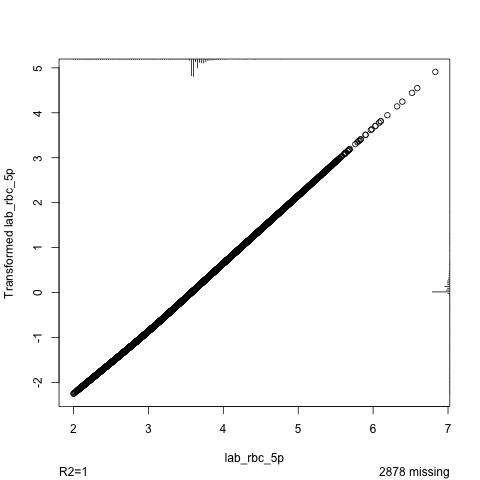

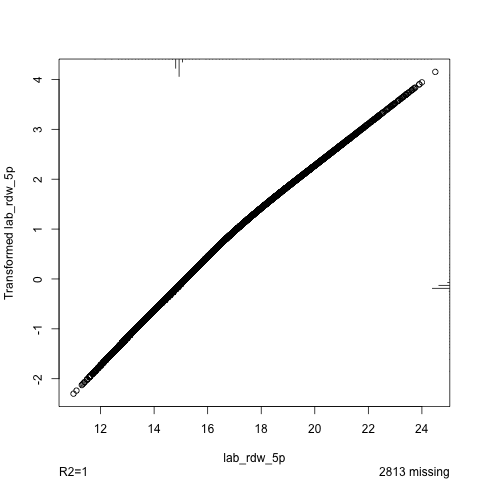

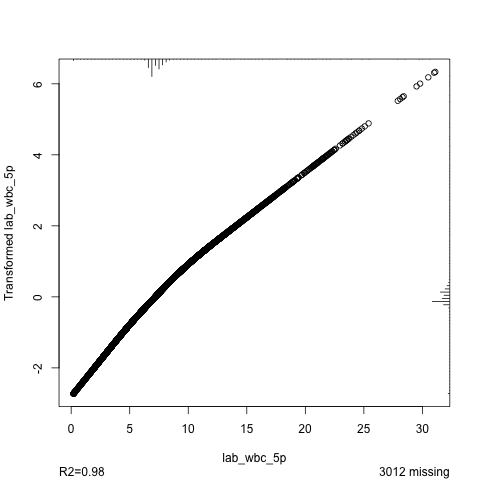

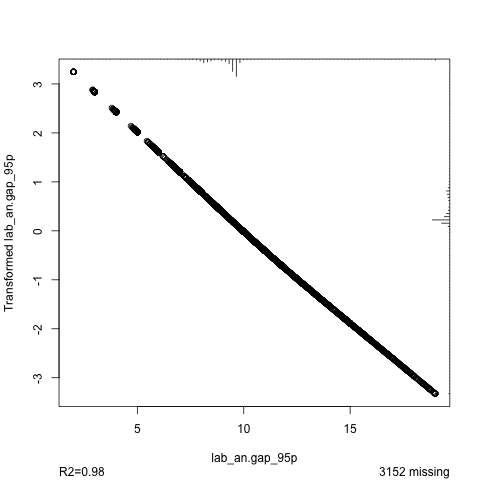

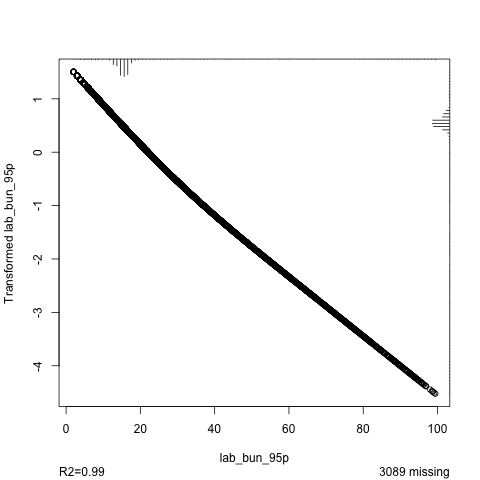

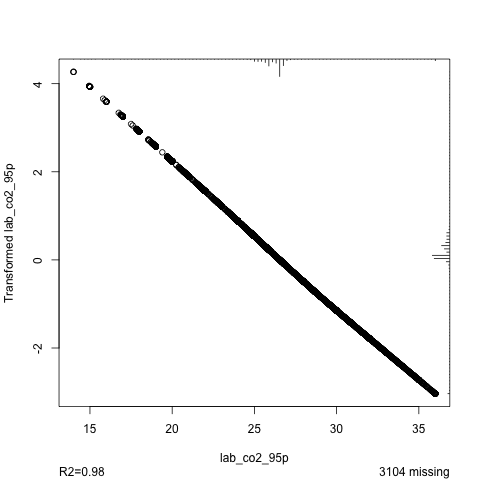

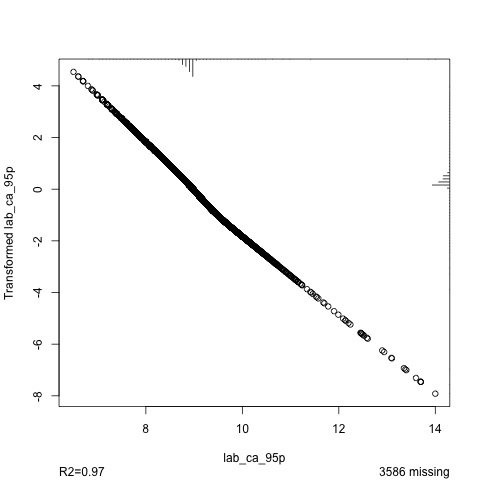

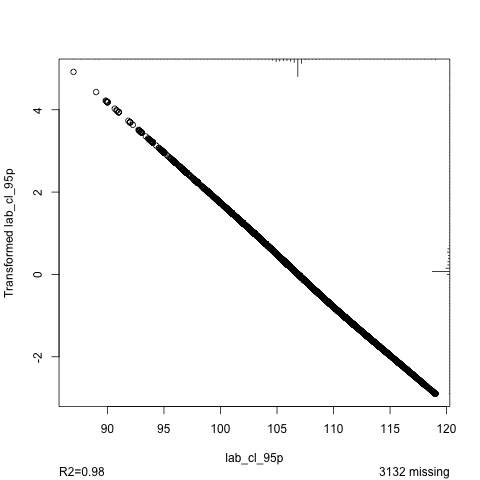

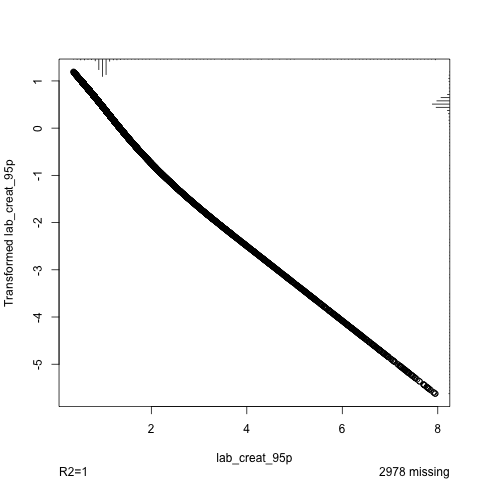

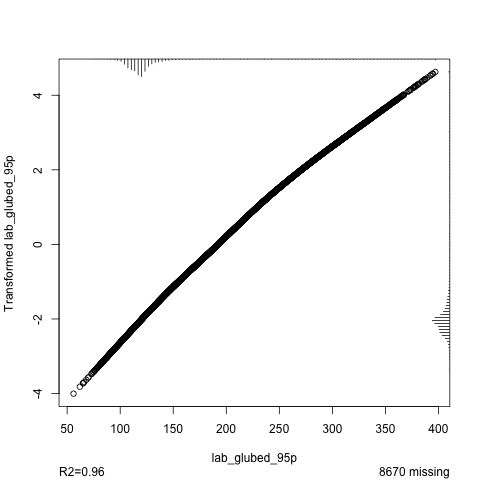

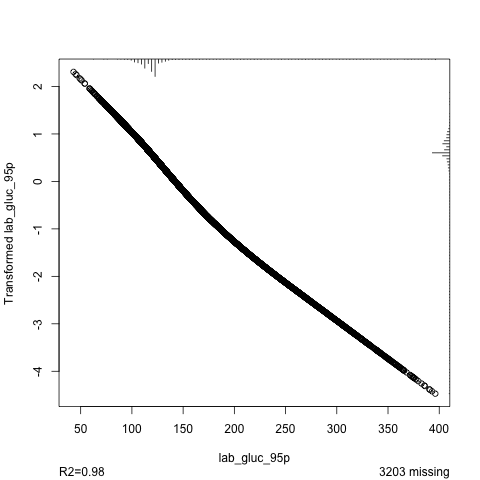

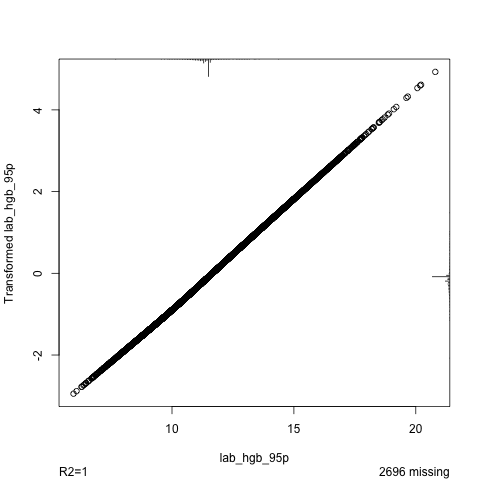

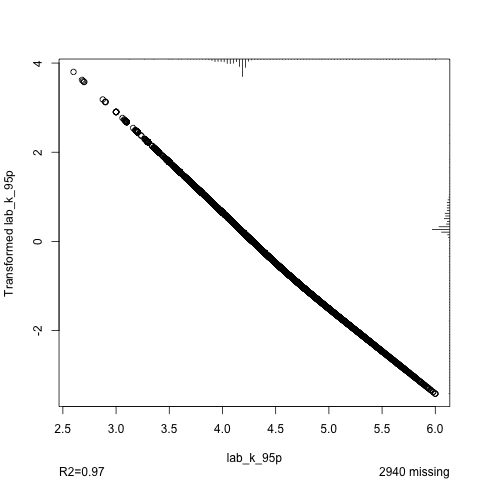

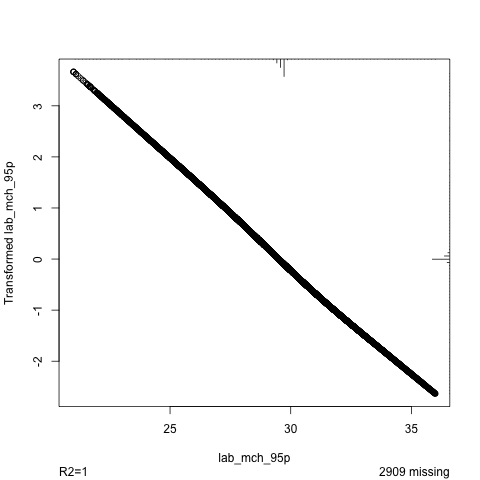

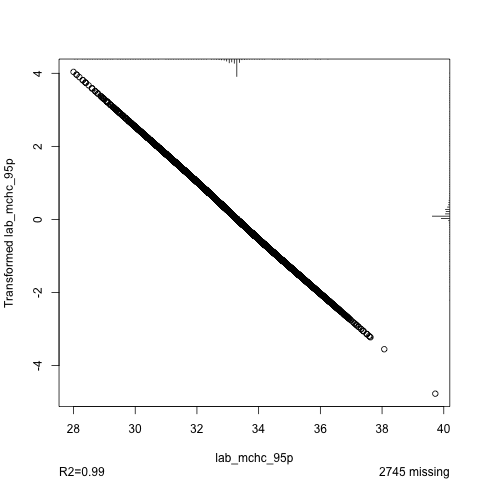

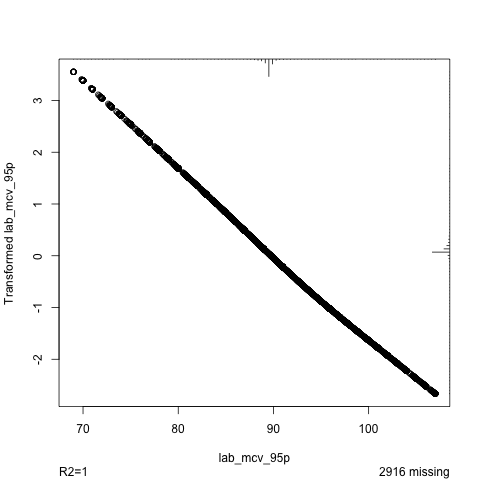

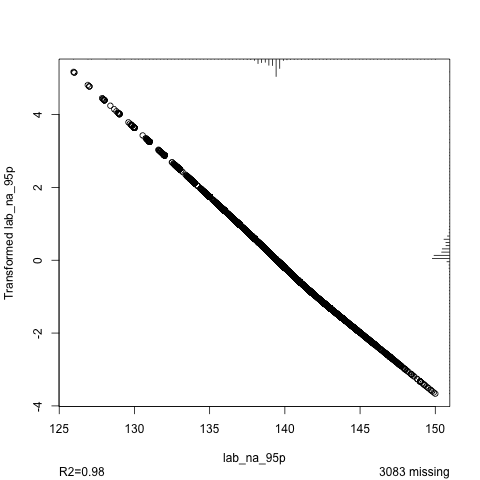

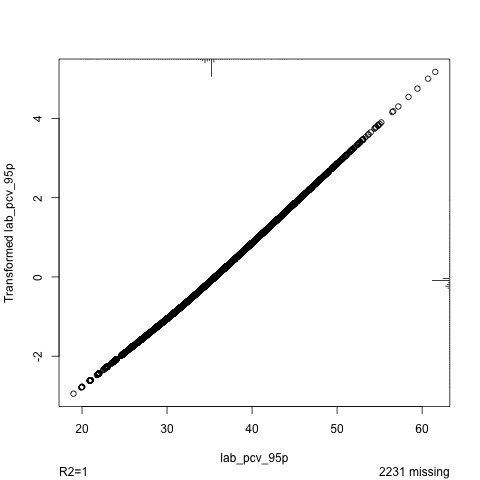

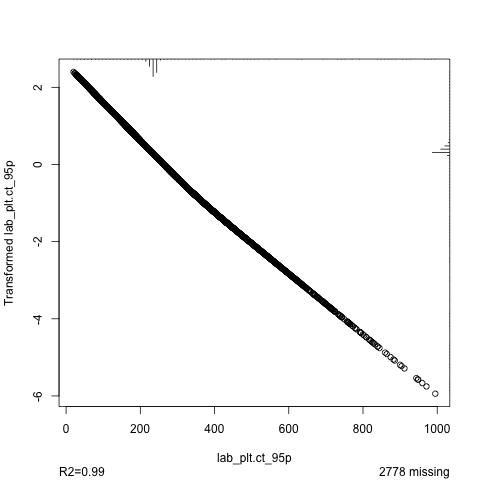

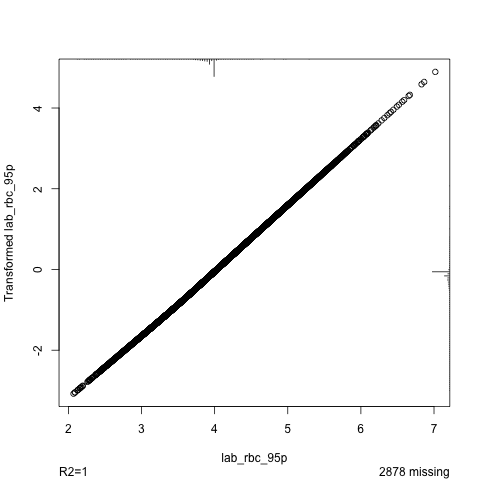

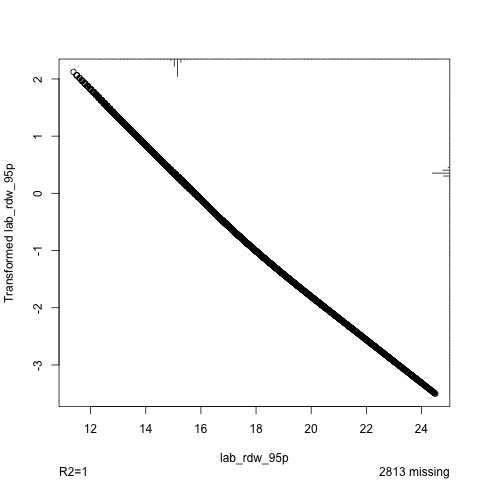

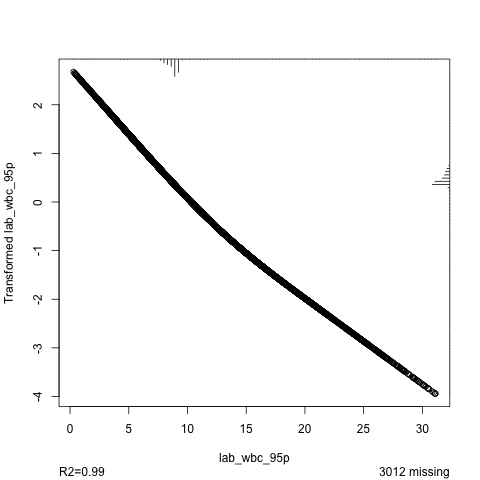

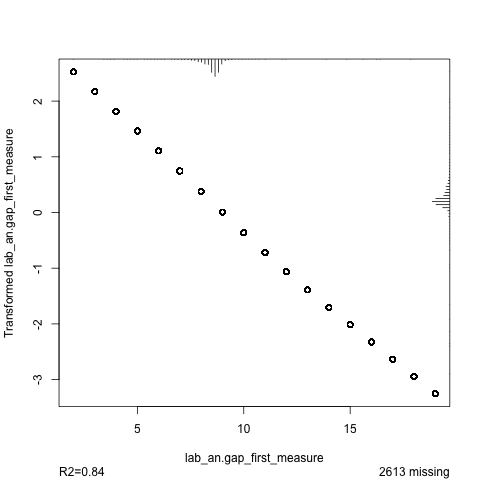

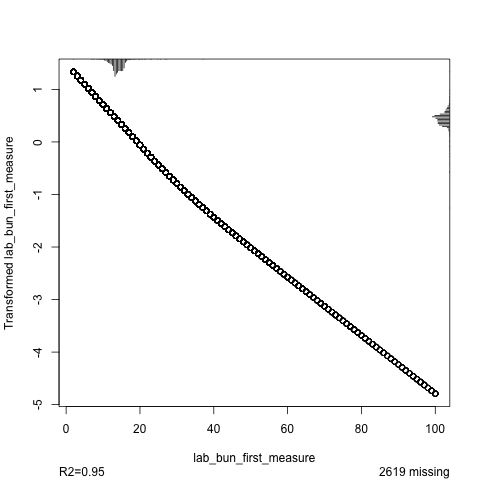

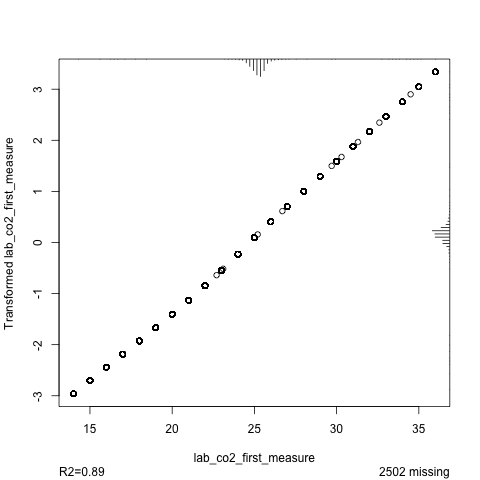

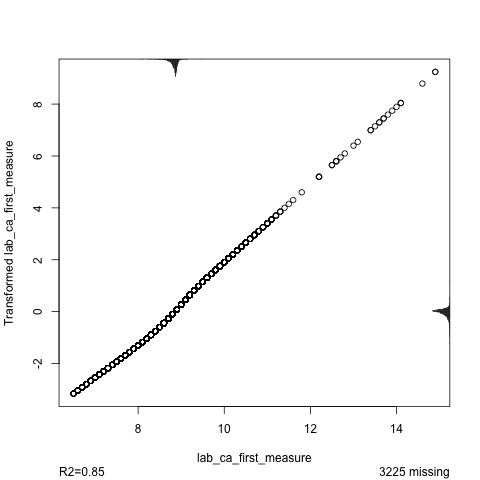

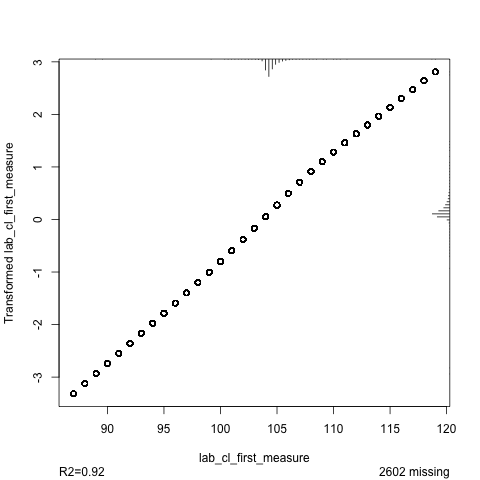

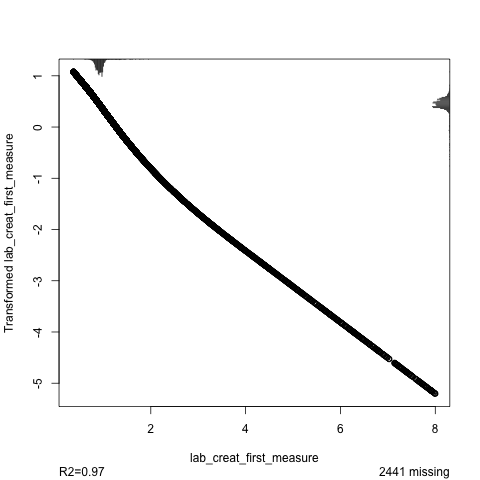

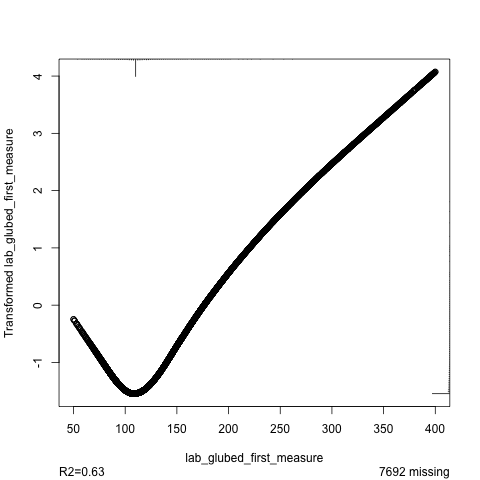

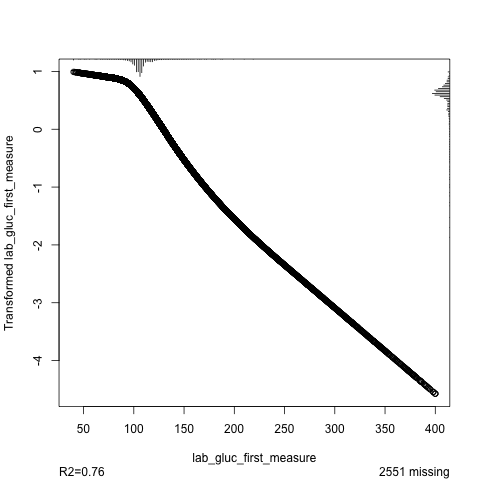

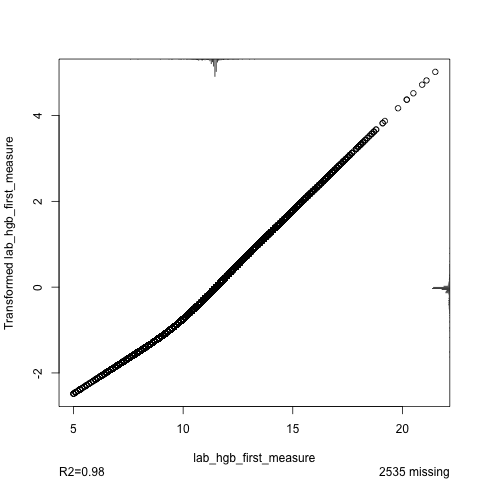

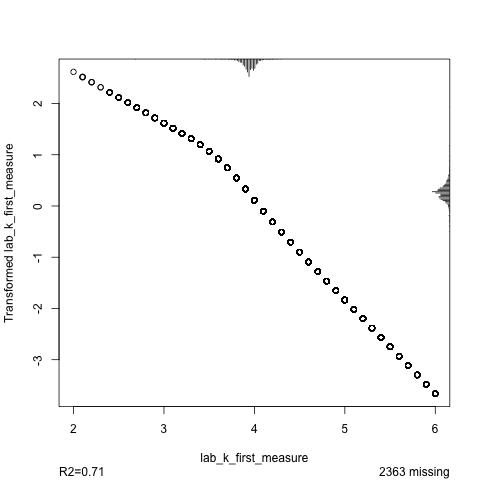

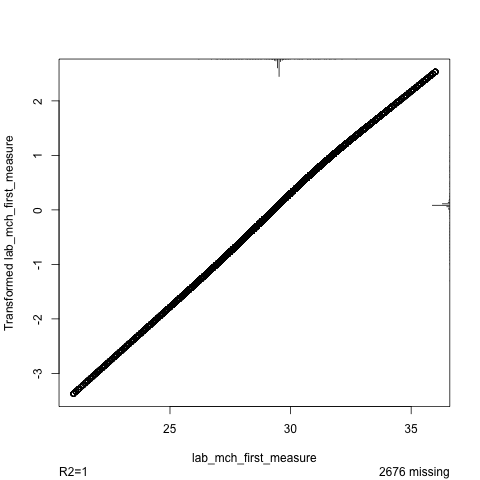

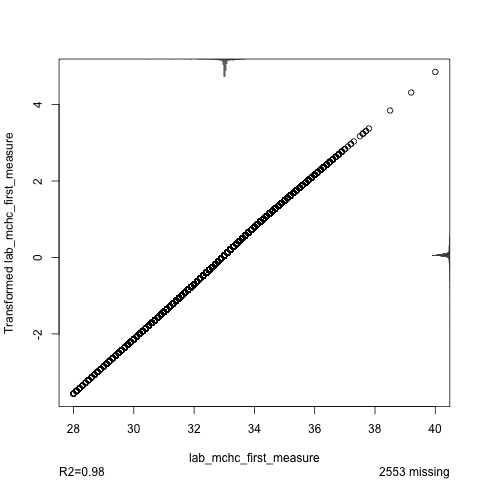

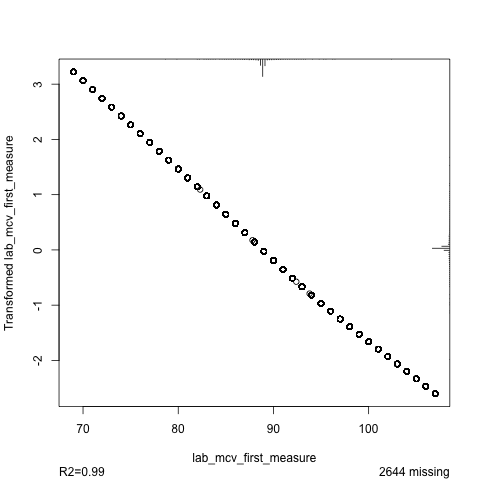

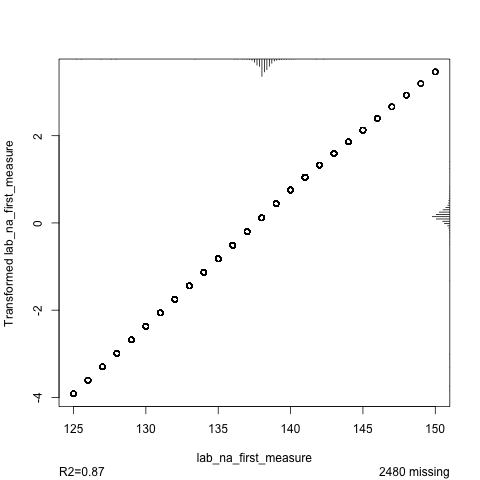

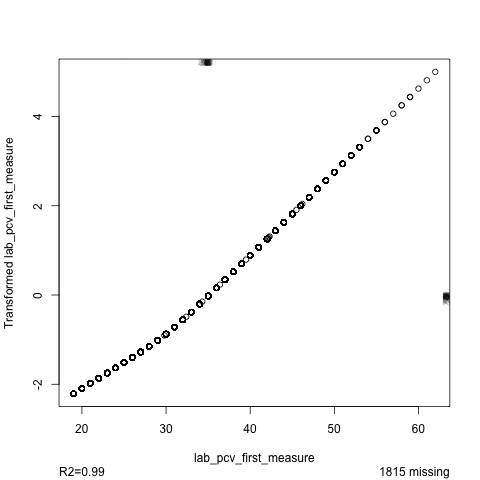

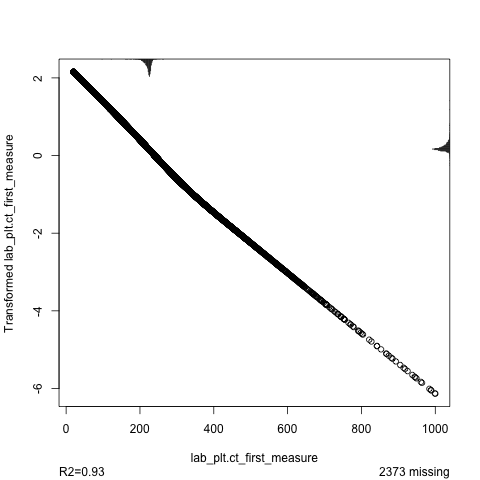

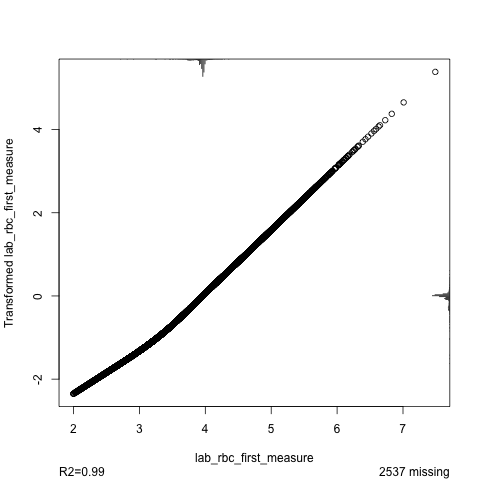

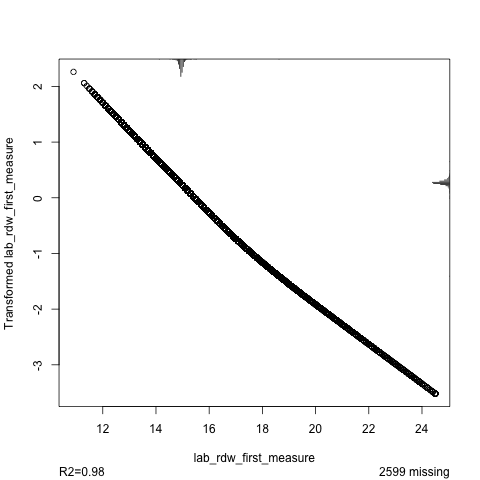

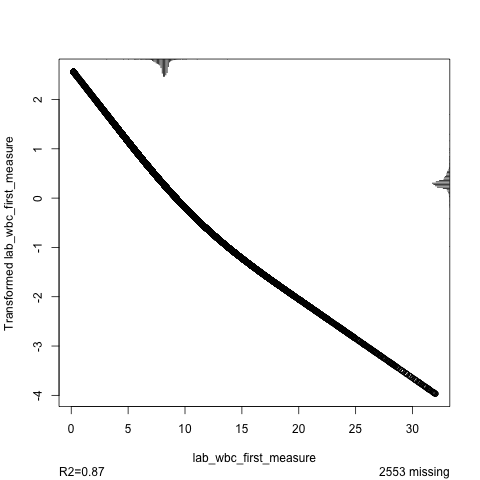

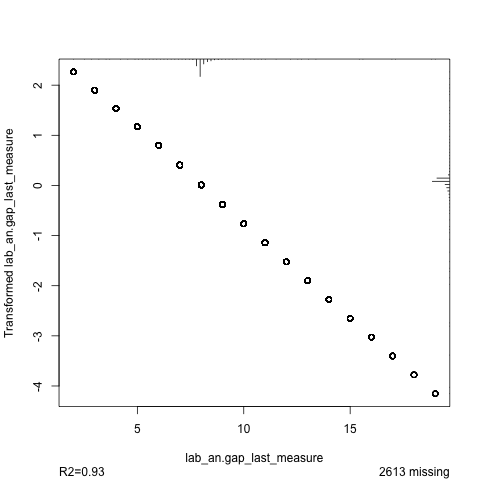

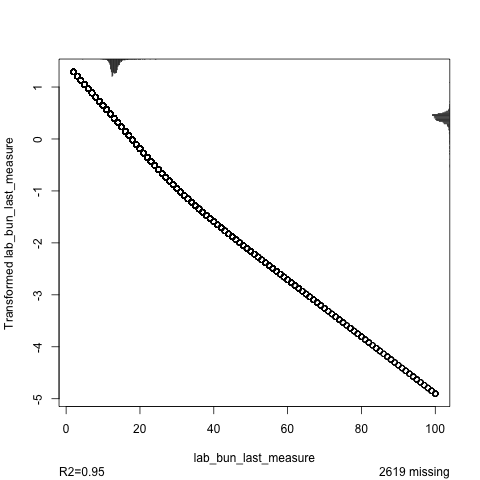

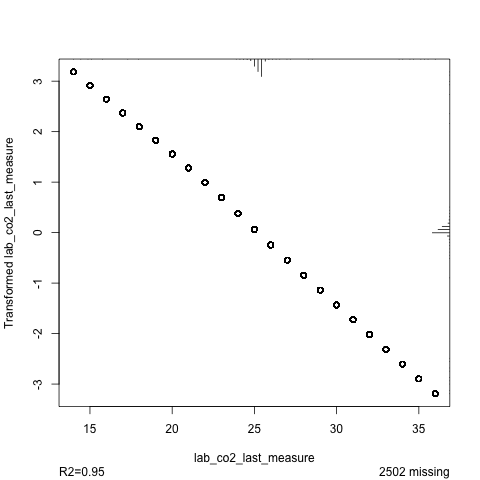

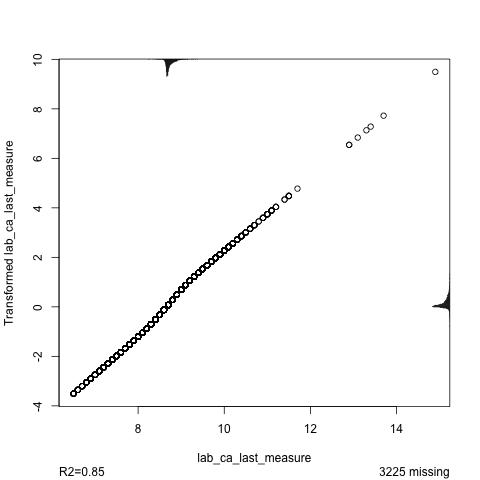

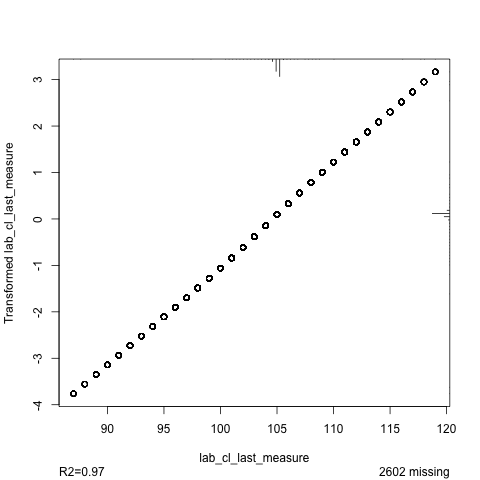

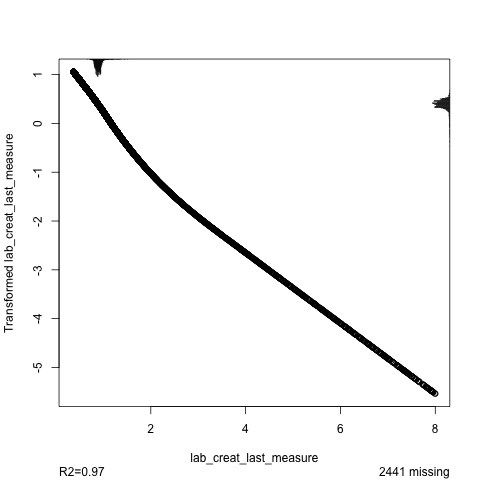

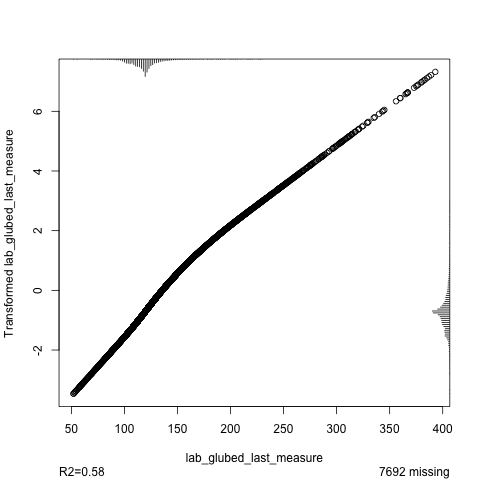

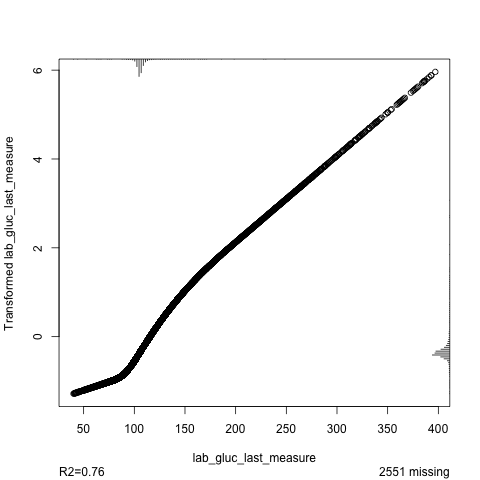

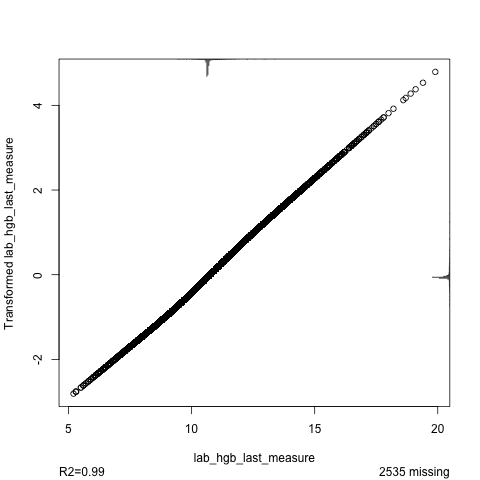

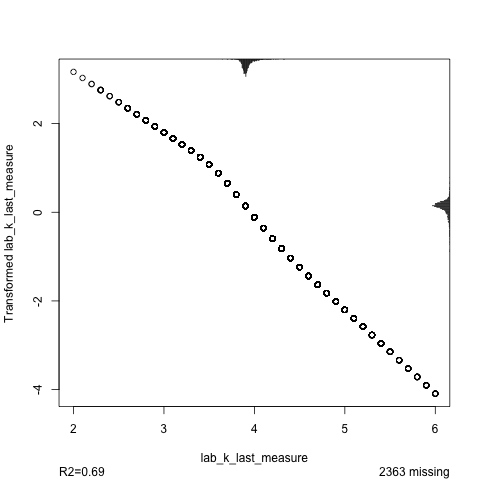

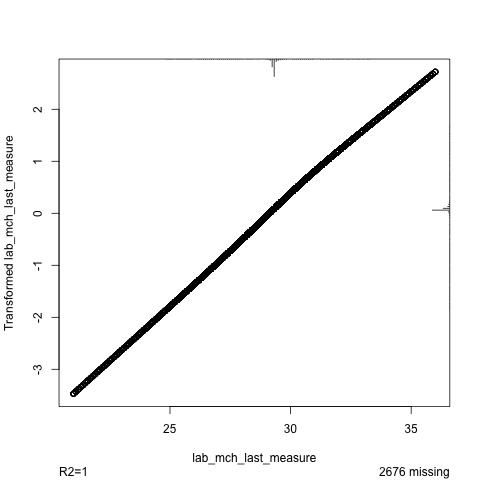

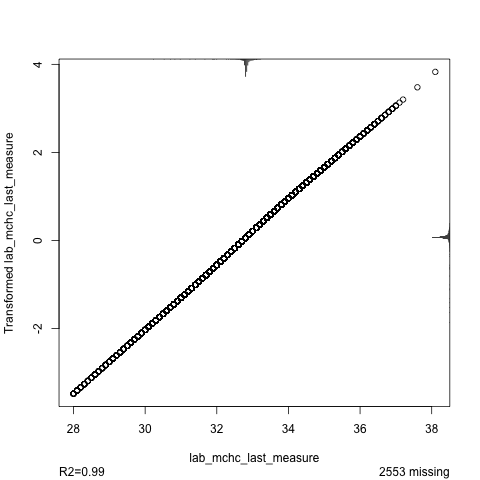

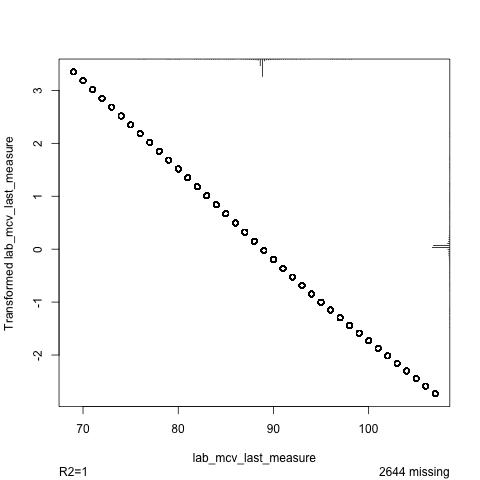

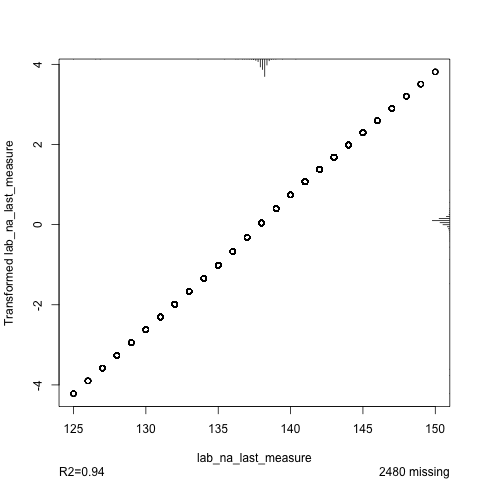

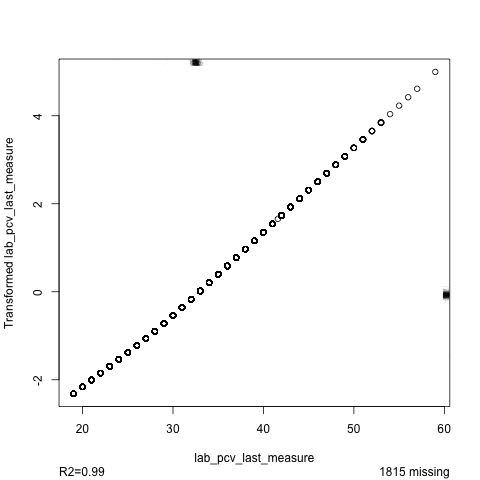

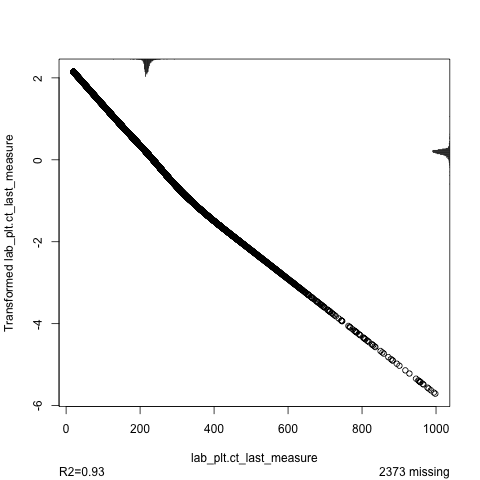

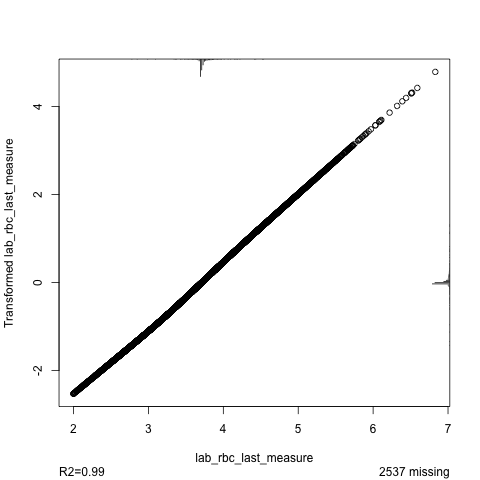

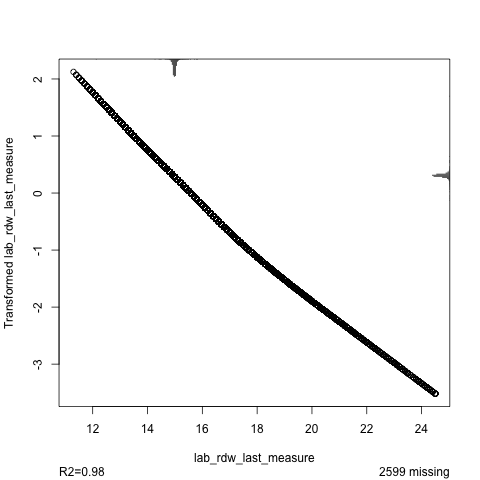

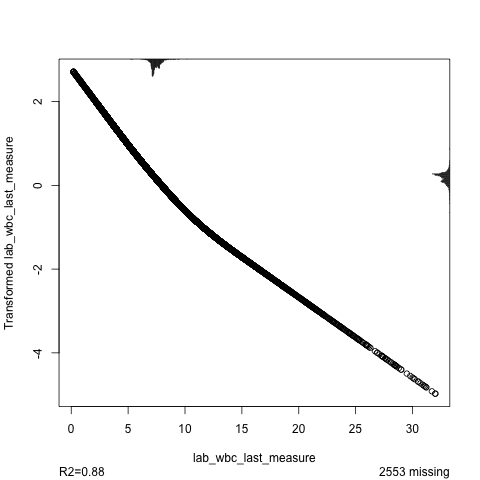

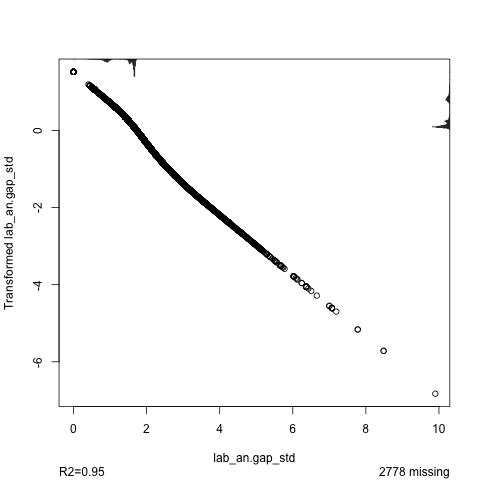

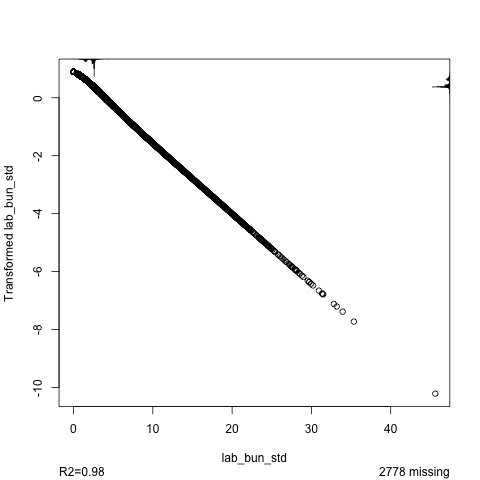

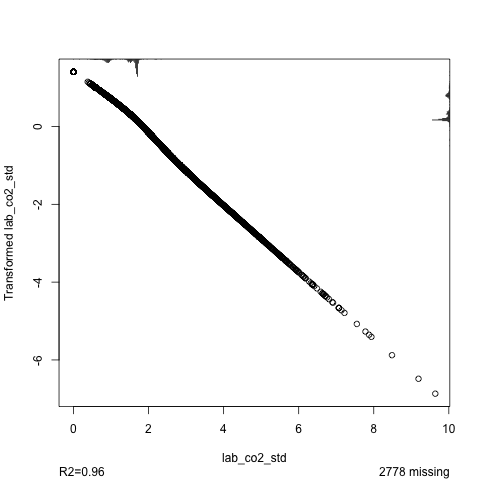

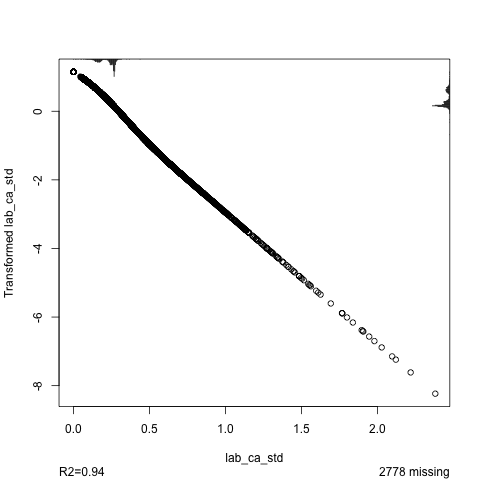

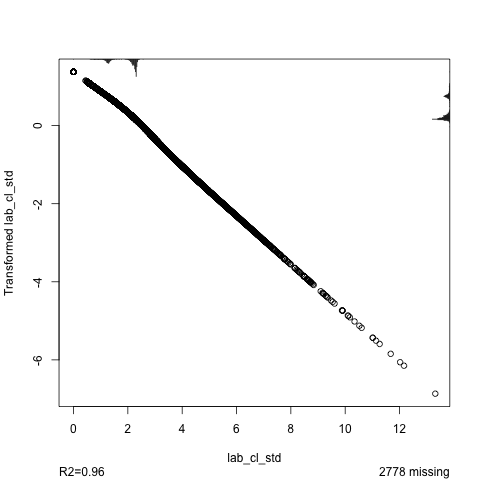

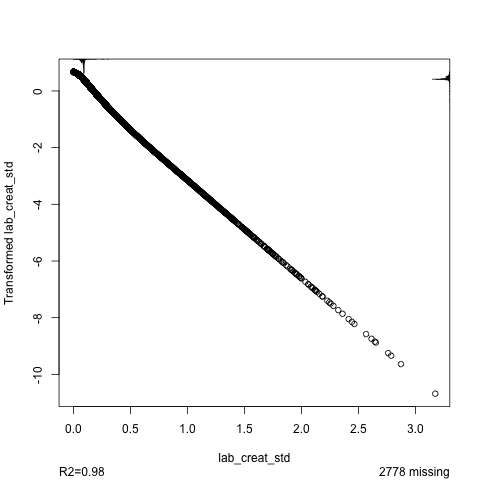

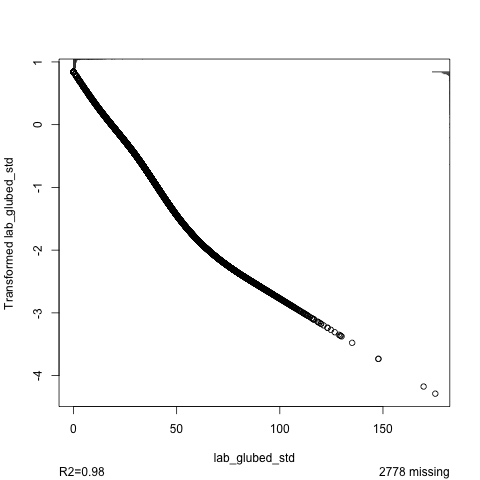

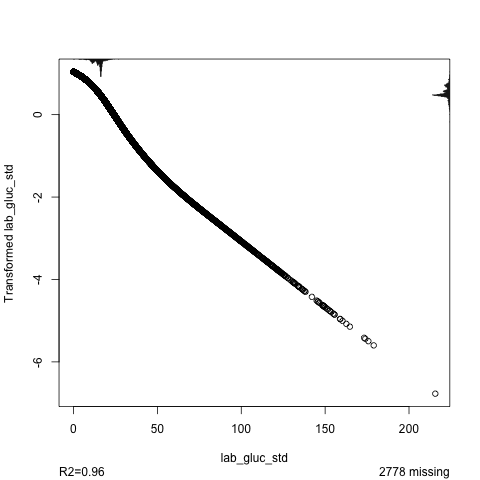

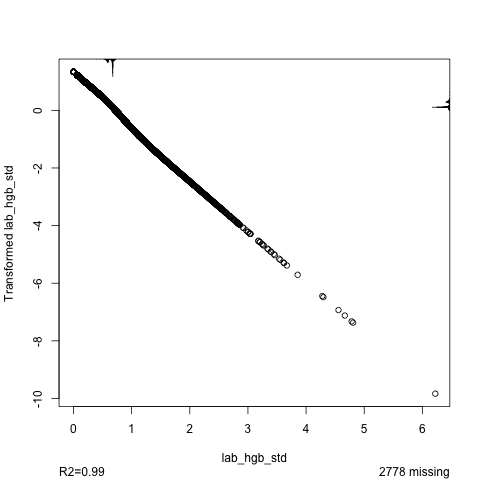

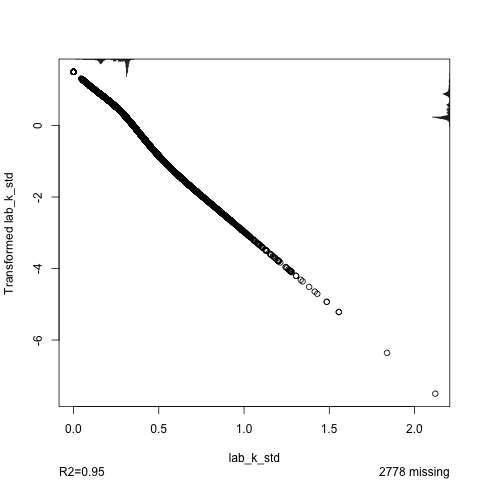

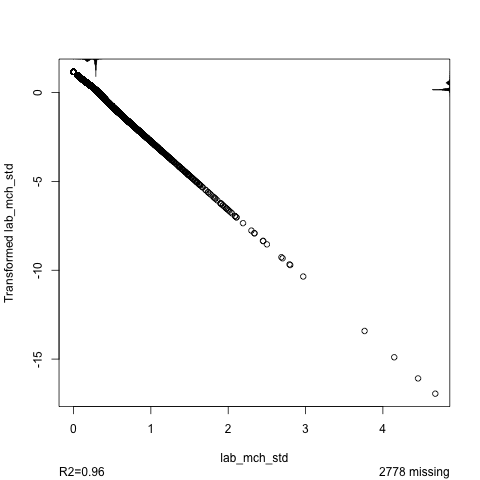

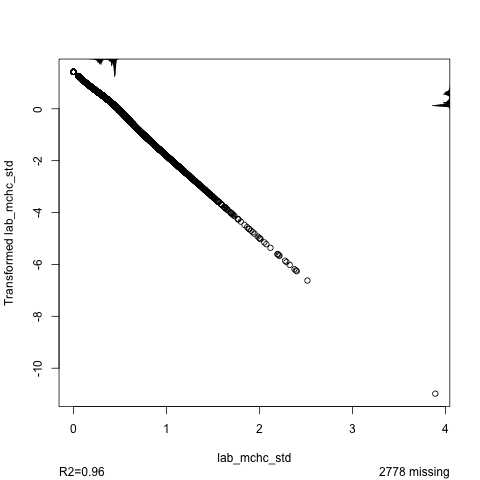

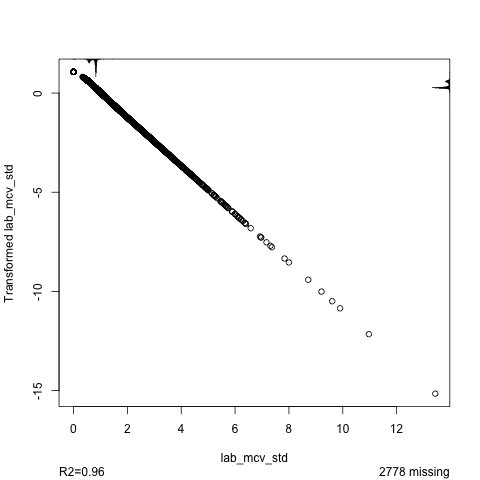

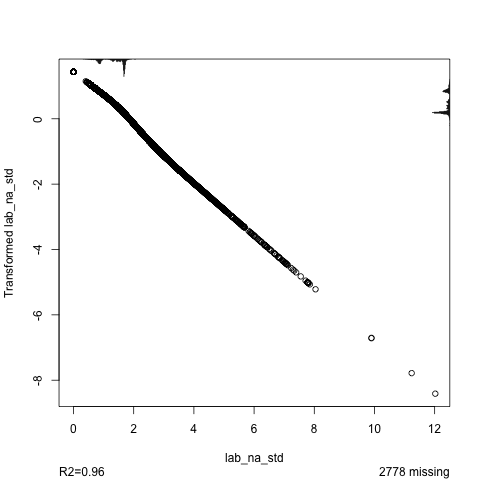

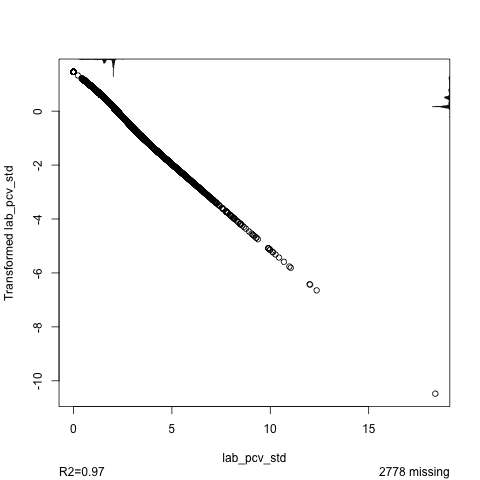

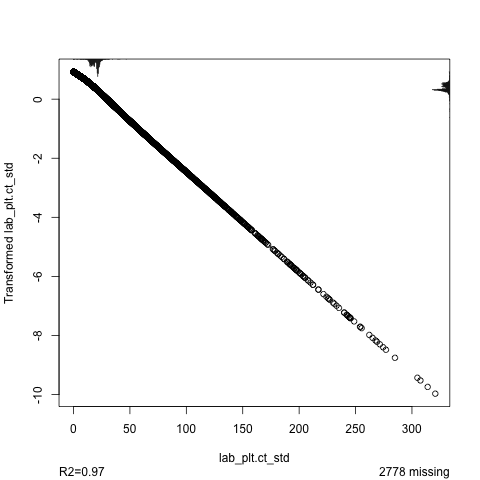

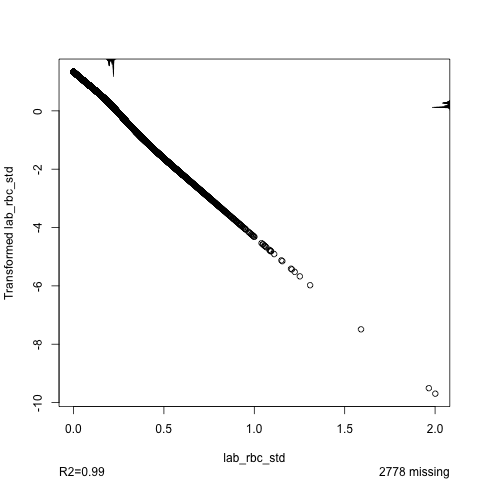

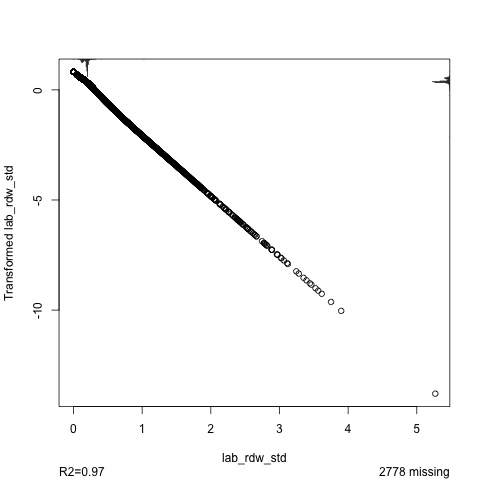

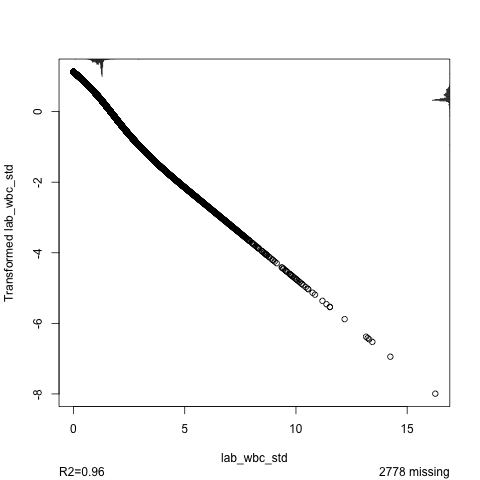

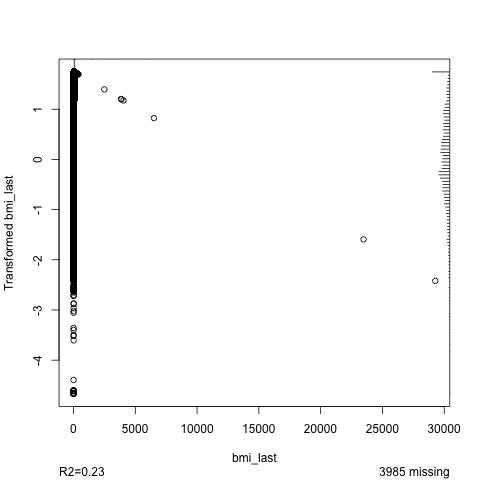

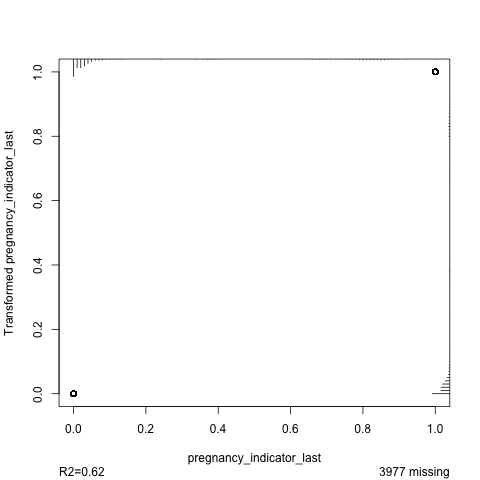

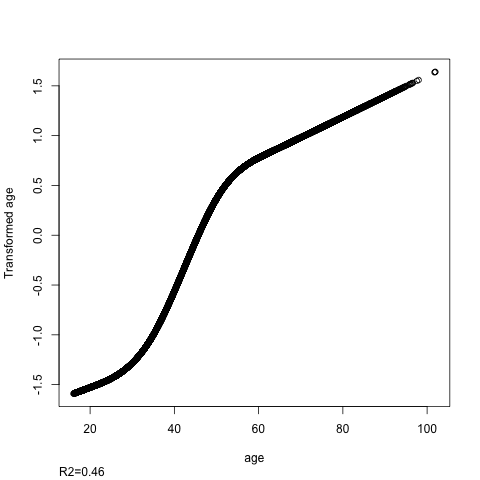

In [17]:
%%R 
# convert all predictors into R formula
vars <- paste(names(train), collapse=' + ')
formula <- as.formula(paste('~', vars))

# perform single imputation using transformed variables & canonical correlation
single_imp <- transcan(formula,
                       categorical=c('readmit_30d', 'sex', 'race'), #, 'pregnancy_indicator'),
                       
                       
                       
                       eps=1, 
                       #iter.max=500, 
                       
                       
                       # variables with fewer than 3 unique knots
                       asis=c('icd_dx_perinatal', 'icd_dx_skin'),
                       transformed=TRUE, 
                       imputed=TRUE, 
                       # if wanting multiple imputations rather than a single:
                       #n.impute=5, 
                       show.na=TRUE, 
                       data=train)

# save to speed up process in case of dead kernel
save(single_imp, file='../data/single_imputation_training.RData')

In [21]:
%%R -o train_imp
load('../data/single_imputation_training.RData')
train_imp <- data.frame(impute.transcan(single_imp, data=train, list.out=T))



Imputed missing values with the following frequencies
 and stored them in variables with their original names:

       lab_an.gap_median           lab_bun_median           lab_co2_median 
                    2613                     2619                     2502 
           lab_ca_median            lab_cl_median         lab_creat_median 
                    3225                     2602                     2441 
       lab_glubed_median          lab_gluc_median           lab_hgb_median 
                    7692                     2551                     2535 
            lab_k_median           lab_mch_median          lab_mchc_median 
                    2363                     2676                     2553 
          lab_mcv_median            lab_na_median           lab_pcv_median 
                    2644                     2480                     1815 
       lab_plt.ct_median           lab_rbc_median           lab_rdw_median 
                    2373                     2537 

## Redundancy Analysis

In [44]:
%%R 
# convert all predictors into R formula
vars <- paste(names(train), collapse=' + ')
vars <- str_replac
formula <- as.formula(paste('~', vars))

print(str_replace(formula, ' + readmit_30d', ''))

[1] "~"                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                 

## Save Imputed Sets to Flat Files

In [ ]:
%%R 
write.csv(train_imp, file='../data/train_imputed.csv')
write.csv(valid_imp, file='../data/valid_imputed.csv')
write.csv(test_imp, file='../data/test_imputed.csv')